In [1]:
#!pip install shap
#!pip install nltk
#!pip install matplotlib
#!pip install seaborn
#!pip install xgboost
#!pip install gensim
!pip install openai==0.28

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/hmohammadi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/hmohammadi/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
YOUR_API_KEY_HERE

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hmohammadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hmohammadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/hmohammadi/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:38:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Overall Classification Report:
              precision    recall  f1-score   support

       human       0.82      0.80      0.81       127
   generated       0.78      0.81      0.79       113

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240


Classification Report for language: nl
              precision    recall  f1-score   support

       human       0.82      0.87      0.84        62
   generated       0.85      0.79      0.81        56

    accuracy                           0.83       118
   macro avg       0.83      0.83      0.83       118
weighted avg       0.83      0.83      0.83       118


Classification Report for language: en
              precision    recall  f1-score   support

       human       0.82      0.72      0.77        65
   generated       0.72      0.82      0.77        57

    accuracy                           0.77       122
   macro avg     

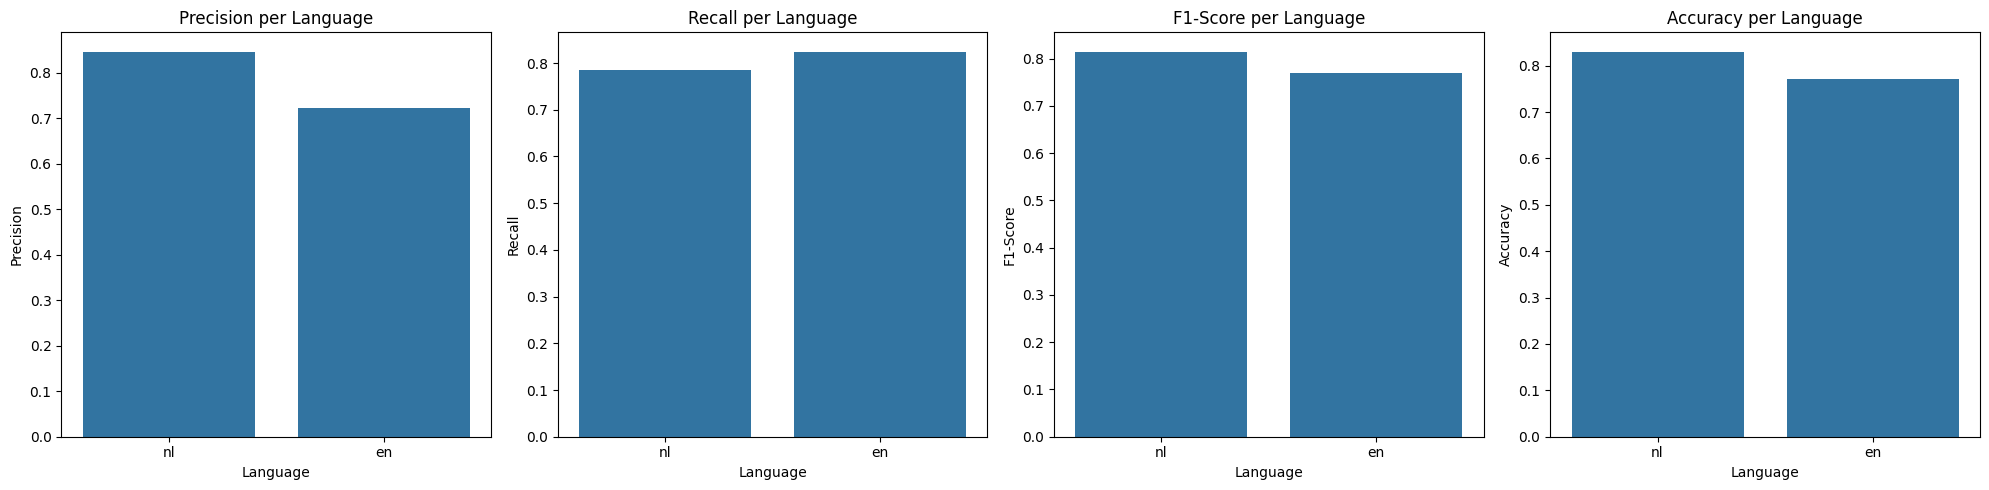


Classification Report for genre: twitter
              precision    recall  f1-score   support

       human       0.88      0.97      0.92        36
   generated       0.97      0.85      0.91        34

    accuracy                           0.91        70
   macro avg       0.92      0.91      0.91        70
weighted avg       0.92      0.91      0.91        70


Classification Report for genre: reviews
              precision    recall  f1-score   support

       human       0.69      0.53      0.60        51
   generated       0.56      0.71      0.62        42

    accuracy                           0.61        93
   macro avg       0.62      0.62      0.61        93
weighted avg       0.63      0.61      0.61        93


Classification Report for genre: news
              precision    recall  f1-score   support

       human       0.89      0.97      0.93        40
   generated       0.97      0.86      0.91        37

    accuracy                           0.92        77
   ma

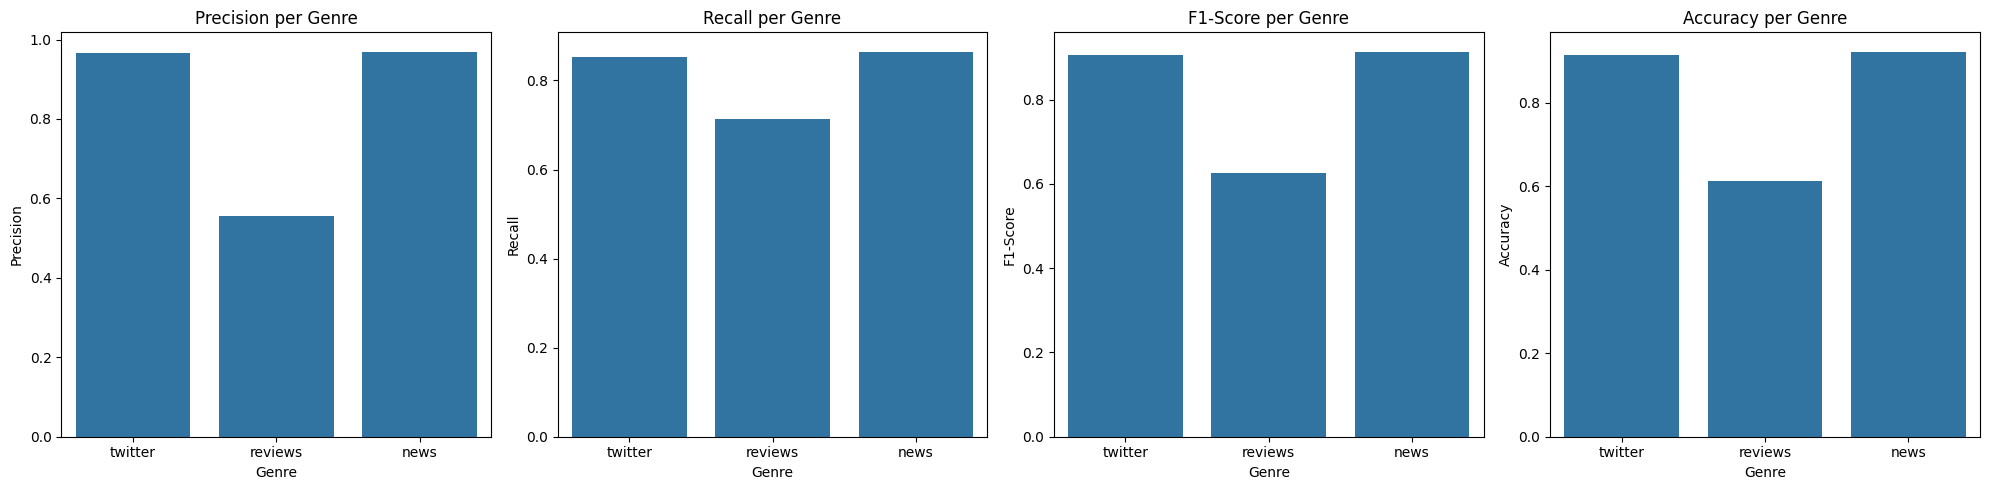


Classification Report for language: nl, genre: twitter
              precision    recall  f1-score   support

       human       0.81      0.93      0.87        14
   generated       0.95      0.86      0.90        21

    accuracy                           0.89        35
   macro avg       0.88      0.89      0.88        35
weighted avg       0.89      0.89      0.89        35


Classification Report for language: nl, genre: reviews
              precision    recall  f1-score   support

       human       0.71      0.71      0.71        24
   generated       0.67      0.67      0.67        21

    accuracy                           0.69        45
   macro avg       0.69      0.69      0.69        45
weighted avg       0.69      0.69      0.69        45


Classification Report for language: nl, genre: news
              precision    recall  f1-score   support

       human       0.92      1.00      0.96        24
   generated       1.00      0.86      0.92        14

    accuracy     

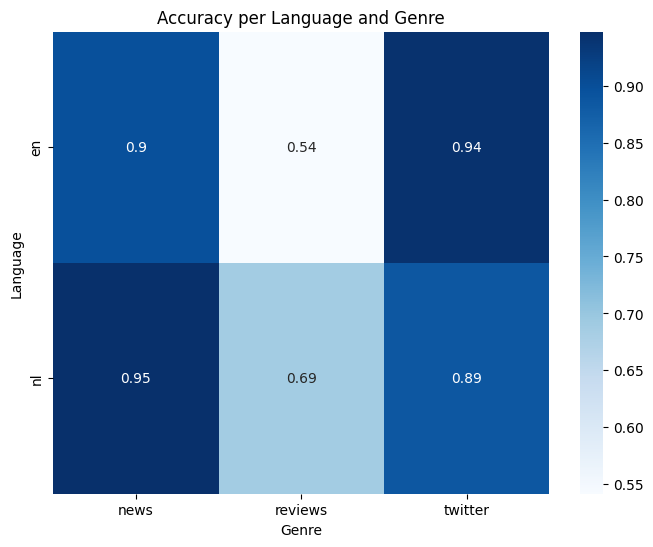

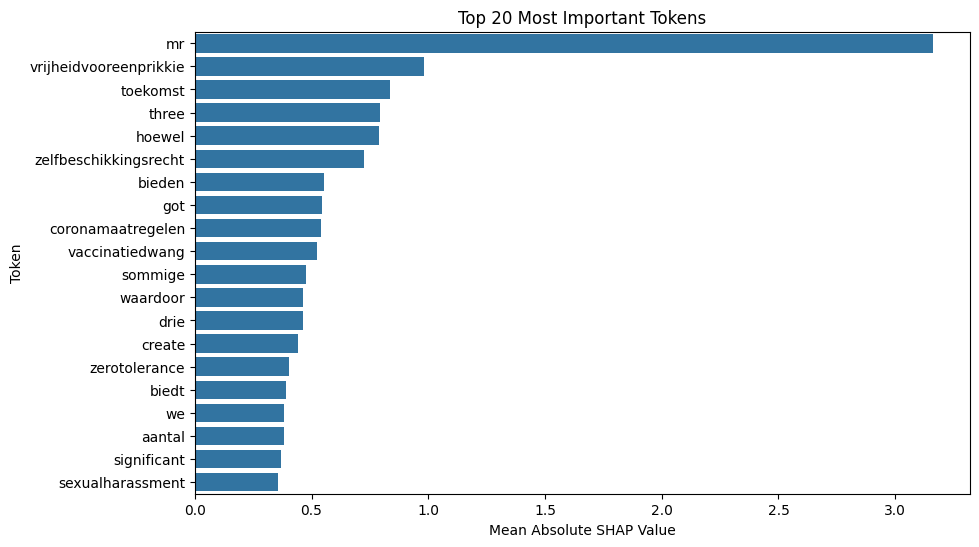

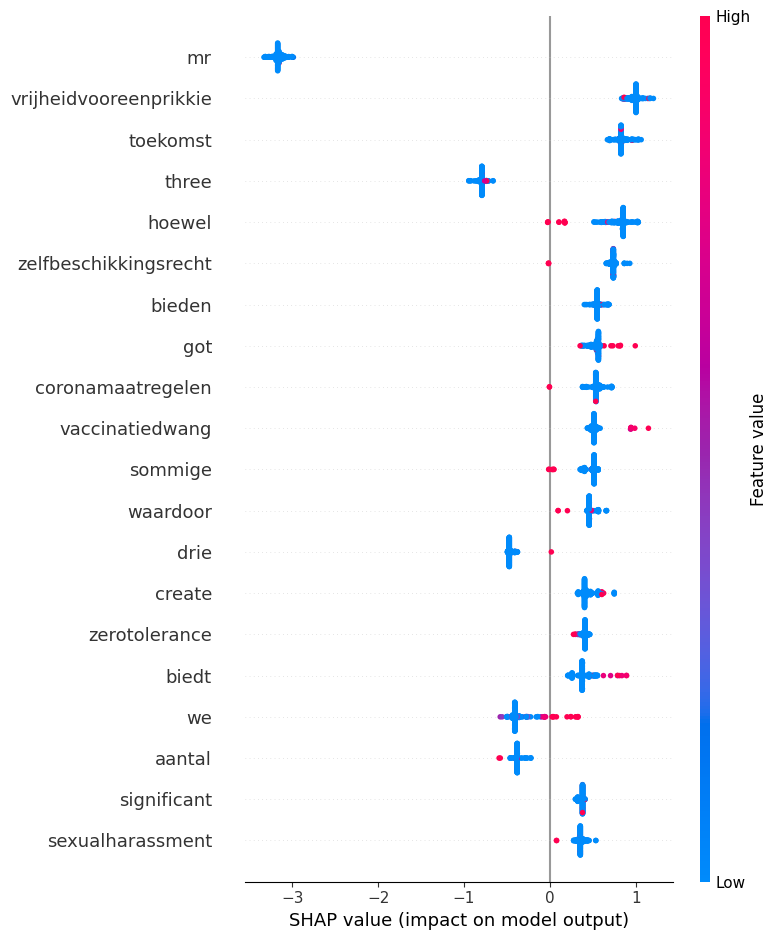

KeyboardInterrupt: Interrupted by user

In [5]:
import os
import shap
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from gensim.models import Word2Vec
import openai
from nltk import pos_tag

# Enable inline plotting
%matplotlib inline

# Load main data
files = ['dev_en_news', 'dev_en_reviews','dev_en_twitter', 'dev_nl_news', 'dev_nl_reviews', 'dev_nl_twitter']
df_list = []

for file in files:
    # Extract 'lang' and 'domain' from filename
    _, lang, domain = file.split("_")
    temp_df = pd.read_csv(f'Data/{file}.csv')
    if 'label' not in temp_df.columns or 'text' not in temp_df.columns:
        raise ValueError(f"Missing required columns in file: {file}")
    temp_df['domain'] = domain
    temp_df['lan'] = lang
    df_list.append(temp_df)

# Concatenate dataframes
df = pd.concat(df_list, ignore_index=True)
df['source'] = 'CLIN33'
df['label1'] = df['label'].apply(lambda label: 'generated' if label == 1 else 'human')

# Drop rows with missing text or label
df.dropna(subset=['text', 'label'], inplace=True)

# Use all data
data = df.copy()

# Data preprocessing
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text, lang):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
    elif lang == 'nl':
        stop_words = set(stopwords.words('dutch'))
    else:
        stop_words = set()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
data['processed_text'] = data.apply(lambda row: preprocess_text(row['text'], row['lan']), axis=1)

# Split data into train and test sets
X = data[['processed_text', 'lan', 'domain']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train_text = X_train['processed_text']
X_test_text = X_test['processed_text']

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_tfidf, y_train)

# Evaluation
y_pred = model.predict(X_test_tfidf)

# Overall metrics
print("Overall Classification Report:")
print(classification_report(y_test, y_pred, target_names=['human', 'generated']))

# Prepare test results DataFrame
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred, name='pred_label')
test_results = pd.concat([X_test, y_test.rename('true_label'), y_pred_series], axis=1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

# Metrics per language
languages = test_results['lan'].unique()
metrics_per_language = []

for lang in languages:
    subset = test_results[test_results['lan'] == lang]
    precision, recall, f1, accuracy = calculate_metrics(subset['true_label'], subset['pred_label'])
    metrics_per_language.append({'Language': lang, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Accuracy': accuracy})
    print(f"\nClassification Report for language: {lang}")
    print(classification_report(subset['true_label'], subset['pred_label'], target_names=['human', 'generated']))

metrics_lang_df = pd.DataFrame(metrics_per_language)

# Plot metrics per language
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

for idx, metric in enumerate(metrics):
    sns.barplot(x='Language', y=metric, data=metrics_lang_df, ax=ax[idx])
    ax[idx].set_title(f'{metric} per Language')

plt.tight_layout()
plt.show()

# Metrics per genre
genres = test_results['domain'].unique()
metrics_per_genre = []

for genre in genres:
    subset = test_results[test_results['domain'] == genre]
    precision, recall, f1, accuracy = calculate_metrics(subset['true_label'], subset['pred_label'])
    metrics_per_genre.append({'Genre': genre, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Accuracy': accuracy})
    print(f"\nClassification Report for genre: {genre}")
    print(classification_report(subset['true_label'], subset['pred_label'], target_names=['human', 'generated']))

metrics_genre_df = pd.DataFrame(metrics_per_genre)

# Plot metrics per genre
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for idx, metric in enumerate(metrics):
    sns.barplot(x='Genre', y=metric, data=metrics_genre_df, ax=ax[idx])
    ax[idx].set_title(f'{metric} per Genre')

plt.tight_layout()
plt.show()

# Metrics per language and genre
metrics_per_lang_genre = []

for lang in languages:
    for genre in genres:
        subset = test_results[(test_results['lan'] == lang) & (test_results['domain'] == genre)]
        if len(subset) > 0:
            precision, recall, f1, accuracy = calculate_metrics(subset['true_label'], subset['pred_label'])
            metrics_per_lang_genre.append({'Language': lang, 'Genre': genre, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Accuracy': accuracy})
            print(f"\nClassification Report for language: {lang}, genre: {genre}")
            print(classification_report(subset['true_label'], subset['pred_label'], target_names=['human', 'generated']))

metrics_lang_genre_df = pd.DataFrame(metrics_per_lang_genre)

# Pivot table for heatmap
pivot_df = metrics_lang_genre_df.pivot(index='Language', columns='Genre', values='Accuracy')


# Plot heatmap of accuracy per language and genre
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='Blues')
plt.title('Accuracy per Language and Genre')
plt.show()

# Explainability using SHAP
explainer = shap.TreeExplainer(model)

# Convert the test data to dense format
X_test_tfidf_dense = X_test_tfidf.toarray()

# Get SHAP values
shap_values = explainer.shap_values(X_test_tfidf_dense)

# Identify influential tokens
def get_influential_tokens(shap_values, vectorizer):
    feature_names = vectorizer.get_feature_names_out()
    influential_tokens = []
    for i in range(len(shap_values)):
        token_importances = shap_values[i]
        top_indices = np.argsort(np.abs(token_importances))[-5:]  # Top 5 tokens per sample
        top_tokens = [feature_names[j] for j in top_indices]
        influential_tokens.append(top_tokens)
    return influential_tokens

influential_tokens = get_influential_tokens(shap_values, vectorizer)

# Save the most effective tokens
feature_names = vectorizer.get_feature_names_out()
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
token_importance_df = pd.DataFrame({
    'token': feature_names,
    'mean_abs_shap_value': mean_abs_shap_values
})
token_importance_df = token_importance_df.sort_values(by='mean_abs_shap_value', ascending=False)
token_importance_df.to_csv('most_effective_tokens.csv', index=False)

# Plot the top 20 most important tokens
top_tokens_df = token_importance_df.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='mean_abs_shap_value', y='token', data=top_tokens_df, orient='h')
plt.title('Top 20 Most Important Tokens')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Token')
plt.show()

# SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, features=X_test_tfidf_dense, feature_names=feature_names)
plt.show()

# Strategy 1: Replacing tokens with the most similar words used by humans
# human_texts = data[data['label1'] == 'human']['processed_text']
# human_tokens = [nltk.word_tokenize(text) for text in human_texts]
# human_model = Word2Vec(human_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Use only the training data for the Word2Vec model
human_texts_train = X_train[y_train == 0]['processed_text']
human_tokens_train = [nltk.word_tokenize(text) for text in human_texts_train]
human_model = Word2Vec(human_tokens_train, vector_size=100, window=5, min_count=1, workers=4)

def replace_with_similar_human_word(text, tokens_to_replace):
    tokens = nltk.word_tokenize(text)
    replacements = {}
    for token in tokens:
        if token in tokens_to_replace:
            if token in human_model.wv:
                similar_words = human_model.wv.most_similar(token, topn=1)
                if similar_words:
                    replacement = similar_words[0][0]
                    text = text.replace(token, replacement, 1)
                    replacements[token] = replacement
    return text, replacements

X_test_modified_1 = []
replacements_strategy1 = []

for i in range(len(X_test)):
    text = X_test.iloc[i]['processed_text']
    tokens_to_replace = influential_tokens[i]
    modified_text, replacements = replace_with_similar_human_word(text, tokens_to_replace)
    X_test_modified_1.append(modified_text)
    replacements_strategy1.append(replacements)

# Strategy 2: Replacing tokens with similar words considering POS tagging
def replace_with_similar_human_word_pos(text, tokens_to_replace):
    tokens = nltk.word_tokenize(text)
    pos_tags = pos_tag(tokens)
    replacements = {}
    for idx, (token, pos) in enumerate(pos_tags):
        if token in tokens_to_replace:
            if token in human_model.wv:
                similar_words = human_model.wv.most_similar(token, topn=10)
                for similar_word, _ in similar_words:
                    similar_pos = pos_tag([similar_word])[0][1]
                    if similar_pos == pos:
                        text = text.replace(token, similar_word, 1)
                        replacements[token] = similar_word
                        break
    return text, replacements

X_test_modified_2 = []
replacements_strategy2 = []

for i in range(len(X_test)):
    text = X_test.iloc[i]['processed_text']
    tokens_to_replace = influential_tokens[i]
    modified_text, replacements = replace_with_similar_human_word_pos(text, tokens_to_replace)
    X_test_modified_2.append(modified_text)
    replacements_strategy2.append(replacements)

# Strategy 3: Token Replacement using GPT-4
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    api_key = input("Please enter your OpenAI API key: ")

openai.api_key = api_key

def replace_tokens_with_gpt4(text, tokens_to_replace):
    replacements = {}
    for token in tokens_to_replace:
        prompt = f"Replace the token '{token}' with a more human-like word in the following text: '{text}'"
        try:
            response = openai.ChatCompletion.create(
                messages=[
                    {"role": "user", "content": prompt}
                ],
                #model="gpt-3.5-turbo",
                model="gpt-4o-mini",

                max_tokens=10,
                n=1,
                stop=None,
                temperature=0.7,
            )
            replacement = response['choices'][0]['message']['content'].strip()
            text = text.replace(token, replacement, 1)
            replacements[token] = replacement
        except Exception as e:
            print(f"Error replacing token '{token}': {e}")
    return text, replacements

X_test_modified_3 = []
replacements_strategy3 = []

for i in range(len(X_test)):
    text = X_test.iloc[i]['processed_text']
    tokens_to_replace = influential_tokens[i]
    modified_text, replacements = replace_tokens_with_gpt4(text, tokens_to_replace)
    X_test_modified_3.append(modified_text)
    replacements_strategy3.append(replacements)

# Strategy 4: Using GPT-4 with genre-specific information
def replace_tokens_with_gpt4_genre(text, tokens_to_replace, genre):
    replacements = {}
    for token in tokens_to_replace:
        prompt = f"Replace the token '{token}' with a more human-like word in the following {genre} text: '{text}'"
        try:
            response = openai.ChatCompletion.create(
                messages=[
                    {"role": "user", "content": prompt}
                ],
                #model="gpt-3.5-turbo",
                model="gpt-4o-mini",
                max_tokens=10,
                n=1,
                stop=None,
                temperature=0.7,
            )
            replacement = response['choices'][0]['message']['content'].strip()
            text = text.replace(token, replacement, 1)
            replacements[token] = replacement
        except Exception as e:
            print(f"Error replacing token '{token}': {e}")
    return text, replacements

X_test_modified_4 = []
replacements_strategy4 = []

for i in range(len(X_test)):
    text = X_test.iloc[i]['processed_text']
    tokens_to_replace = influential_tokens[i]
    genre = X_test.iloc[i]['domain']
    modified_text, replacements = replace_tokens_with_gpt4_genre(text, tokens_to_replace, genre)
    X_test_modified_4.append(modified_text)
    replacements_strategy4.append(replacements)

# Test the model on the revised texts
X_test_modified_1_tfidf = vectorizer.transform(X_test_modified_1)
X_test_modified_2_tfidf = vectorizer.transform(X_test_modified_2)
X_test_modified_3_tfidf = vectorizer.transform(X_test_modified_3)
X_test_modified_4_tfidf = vectorizer.transform(X_test_modified_4)

y_pred_modified_1 = model.predict(X_test_modified_1_tfidf)
y_pred_modified_2 = model.predict(X_test_modified_2_tfidf)
y_pred_modified_3 = model.predict(X_test_modified_3_tfidf)
y_pred_modified_4 = model.predict(X_test_modified_4_tfidf)

# Evaluate the performance on modified texts
def get_metrics_dict(y_true, y_pred, strategy_name):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)
    return {
        'Strategy': strategy_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    }

metrics_original = get_metrics_dict(y_test, y_pred, 'Original')
metrics_strategy1 = get_metrics_dict(y_test, y_pred_modified_1, 'Strategy 1')
metrics_strategy2 = get_metrics_dict(y_test, y_pred_modified_2, 'Strategy 2')
metrics_strategy3 = get_metrics_dict(y_test, y_pred_modified_3, 'Strategy 3')
metrics_strategy4 = get_metrics_dict(y_test, y_pred_modified_4, 'Strategy 4')

metrics_all_strategies = pd.DataFrame([
    metrics_original,
    metrics_strategy1,
    metrics_strategy2,
    metrics_strategy3,
    metrics_strategy4
])

# Plot comparison of strategies
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for idx, metric in enumerate(metrics):
    sns.barplot(x='Strategy', y=metric, data=metrics_all_strategies, ax=ax[idx])
    ax[idx].set_title(f'{metric} Comparison')
    ax[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print classification reports for each strategy
print("\nResults for Strategy 1:")
print(classification_report(y_test, y_pred_modified_1, target_names=['human', 'generated']))

print("\nResults for Strategy 2:")
print(classification_report(y_test, y_pred_modified_2, target_names=['human', 'generated']))

print("\nResults for Strategy 3:")
print(classification_report(y_test, y_pred_modified_3, target_names=['human', 'generated']))

print("\nResults for Strategy 4:")
print(classification_report(y_test, y_pred_modified_4, target_names=['human', 'generated']))

# Save the tokens that were replaced as well as the replacements and the final datasets
def save_strategy_results(strategy_number, modified_texts, replacements):
    results_df = pd.DataFrame({
        'original_text': X_test['processed_text'],
        'modified_text': modified_texts,
        'replacements': replacements,
        'true_label': y_test,
        'pred_label': eval(f'y_pred_modified_{strategy_number}')
    })
    results_df.to_csv(f'strategy{strategy_number}_results.csv', index=False)

save_strategy_results(1, X_test_modified_1, replacements_strategy1)
save_strategy_results(2, X_test_modified_2, replacements_strategy2)
save_strategy_results(3, X_test_modified_3, replacements_strategy3)
save_strategy_results(4, X_test_modified_4, replacements_strategy4)

In [ ]:
import pickle

# Save the trained model
with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

In [ ]:
#new code

In [ ]:
YOUR_API_KEY_HERE

/home/hmohammadi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hmohammadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hmohammadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/hmohammadi/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:39:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Overall Classification Report (Original):
              precision    recall  f1-score   support

       human       0.82      0.80      0.81       127
   generated       0.78      0.81      0.79       113

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240


Classification Report for language: nl (Original)
              precision    recall  f1-score   support

       human       0.82      0.87      0.84        62
   generated       0.85      0.79      0.81        56

    accuracy                           0.83       118
   macro avg       0.83      0.83      0.83       118
weighted avg       0.83      0.83      0.83       118


Classification Report for language: en (Original)
              precision    recall  f1-score   support

       human       0.82      0.72      0.77        65
   generated       0.72      0.82      0.77        57

    accuracy                          

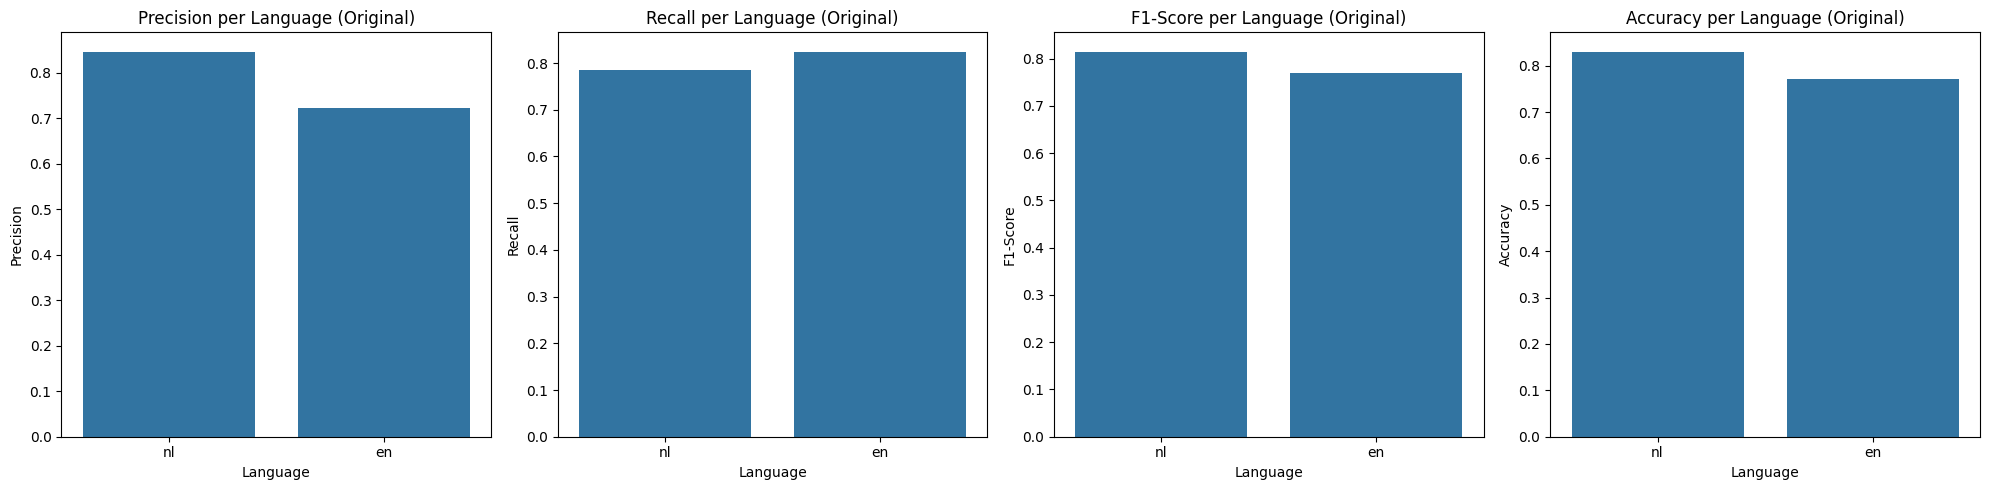


Classification Report for genre: twitter (Original)
              precision    recall  f1-score   support

       human       0.88      0.97      0.92        36
   generated       0.97      0.85      0.91        34

    accuracy                           0.91        70
   macro avg       0.92      0.91      0.91        70
weighted avg       0.92      0.91      0.91        70


Classification Report for genre: reviews (Original)
              precision    recall  f1-score   support

       human       0.69      0.53      0.60        51
   generated       0.56      0.71      0.62        42

    accuracy                           0.61        93
   macro avg       0.62      0.62      0.61        93
weighted avg       0.63      0.61      0.61        93


Classification Report for genre: news (Original)
              precision    recall  f1-score   support

       human       0.89      0.97      0.93        40
   generated       0.97      0.86      0.91        37

    accuracy              

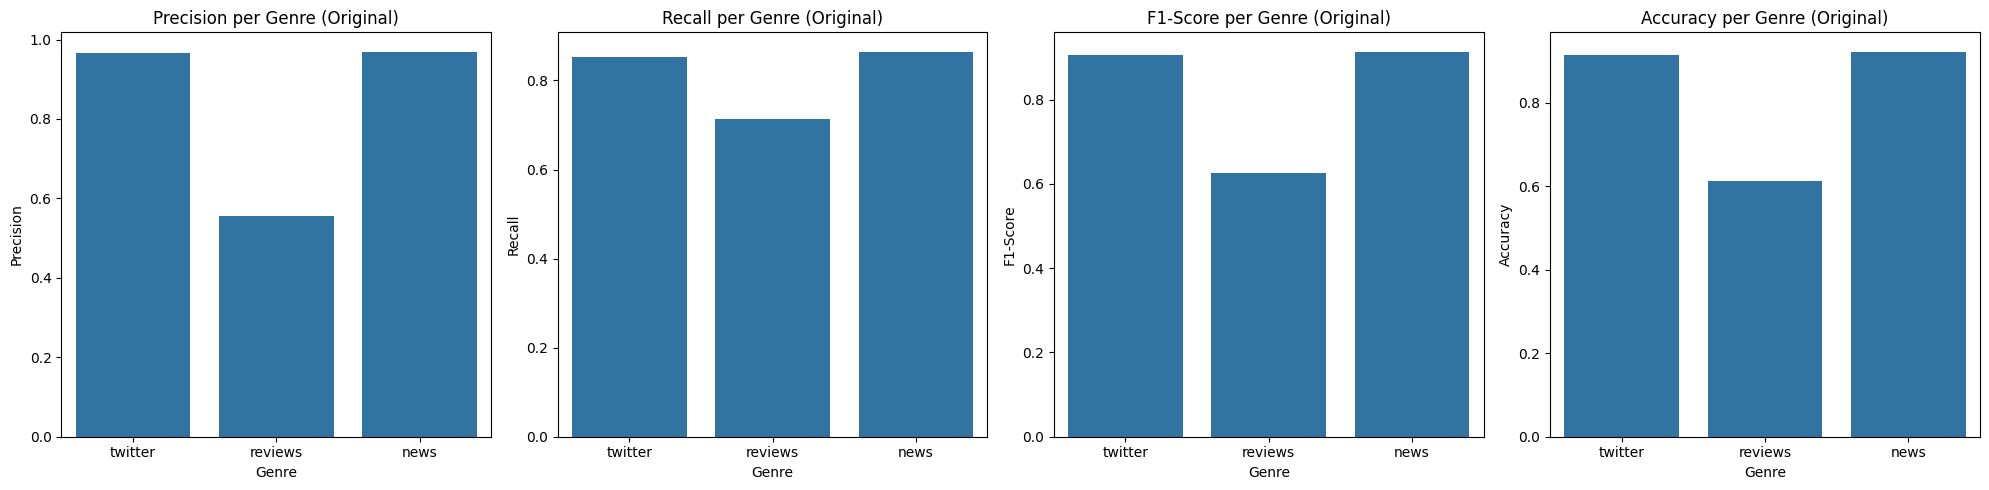


Classification Report for language: nl, genre: twitter (Original)
              precision    recall  f1-score   support

       human       0.81      0.93      0.87        14
   generated       0.95      0.86      0.90        21

    accuracy                           0.89        35
   macro avg       0.88      0.89      0.88        35
weighted avg       0.89      0.89      0.89        35


Classification Report for language: nl, genre: reviews (Original)
              precision    recall  f1-score   support

       human       0.71      0.71      0.71        24
   generated       0.67      0.67      0.67        21

    accuracy                           0.69        45
   macro avg       0.69      0.69      0.69        45
weighted avg       0.69      0.69      0.69        45


Classification Report for language: nl, genre: news (Original)
              precision    recall  f1-score   support

       human       0.92      1.00      0.96        24
   generated       1.00      0.86      

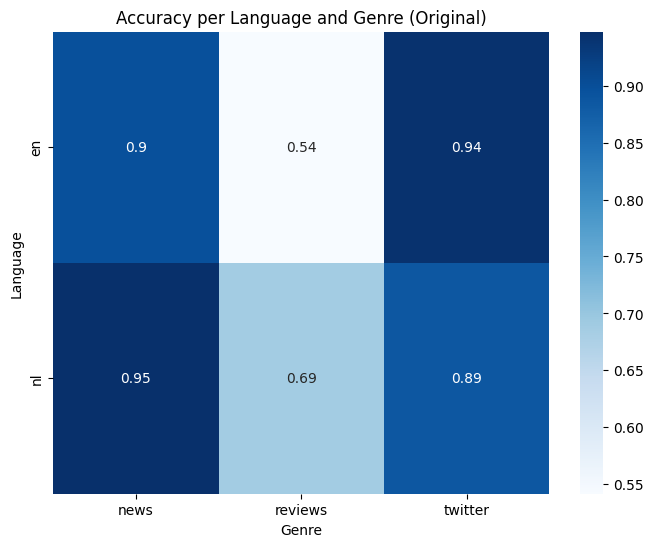

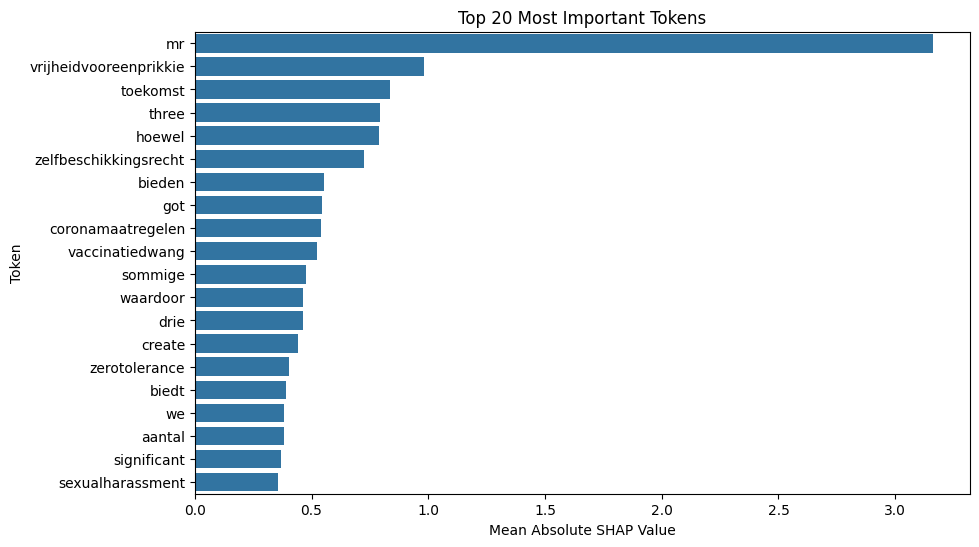

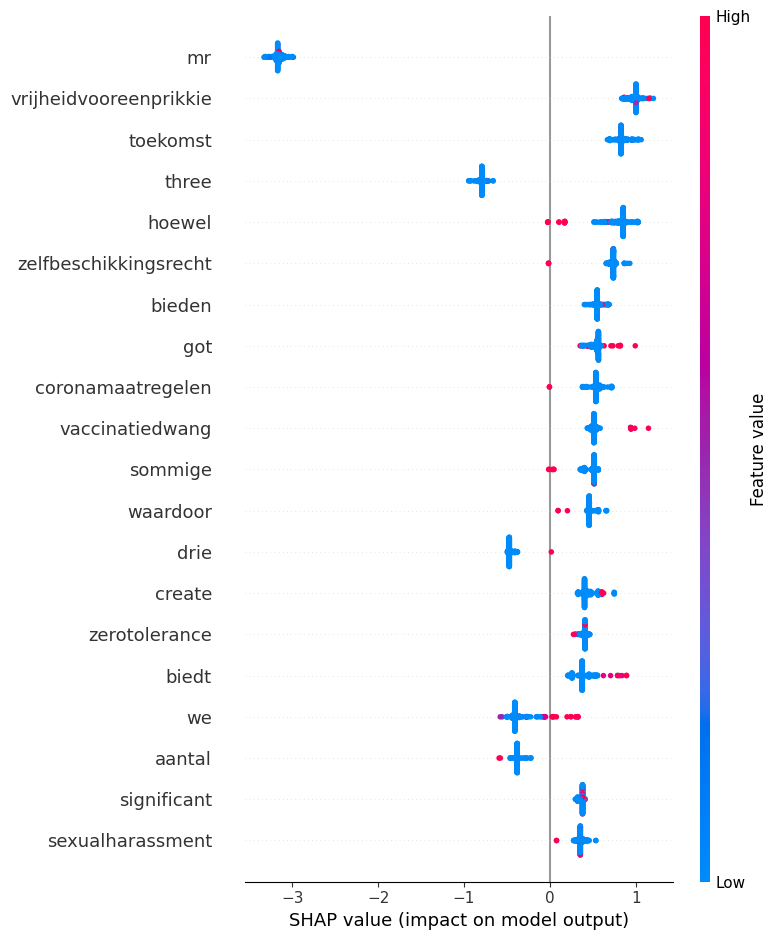

Please enter your OpenAI API key:  YOUR_API_KEY_HERE


Error replacing token 'vrijheidvooreenprikkie': Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)

Label Flip Rates (AI -> Human) for each strategy:
      Strategy  LabelFlipRate
0  Strategy 1       0.159292
1  Strategy 2       0.070796
2  Strategy 3       0.044248
3  Strategy 4       0.035398


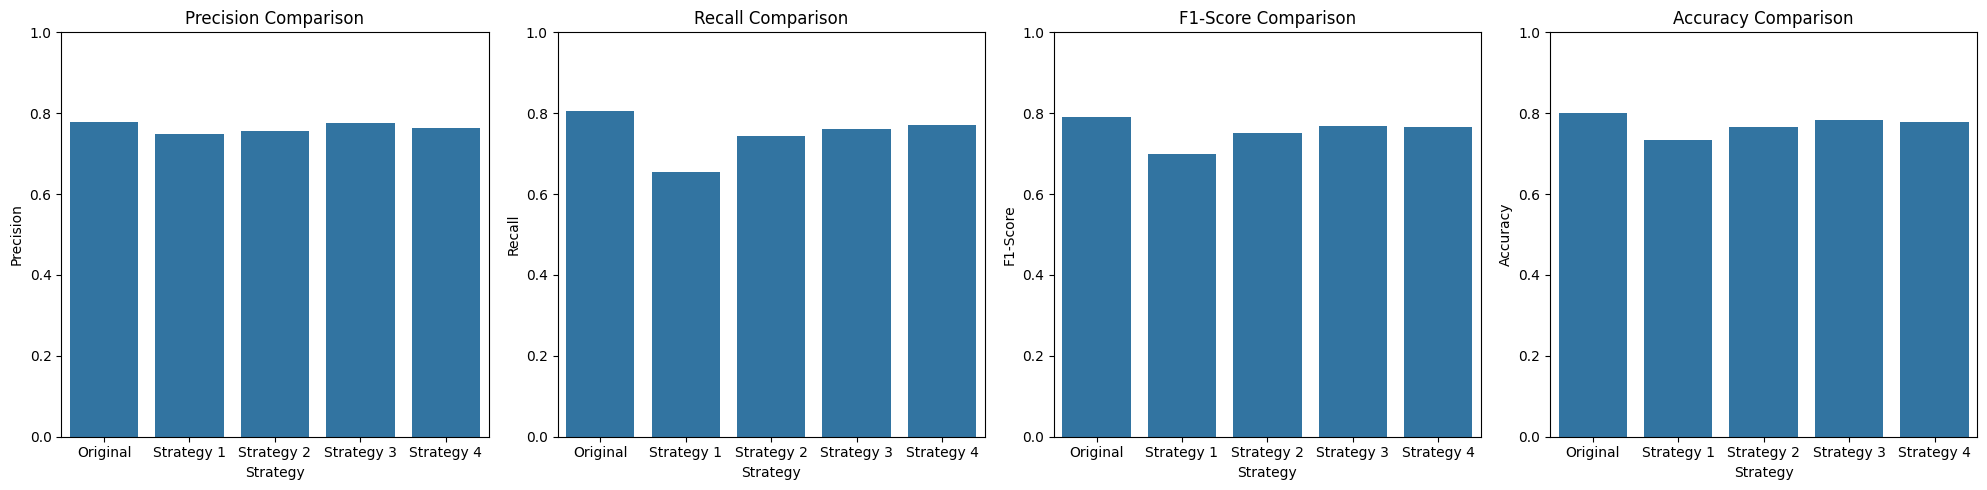



=== Classification Reports ===

Original Texts:
              precision    recall  f1-score   support

       human       0.82      0.80      0.81       127
   generated       0.78      0.81      0.79       113

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240


Results for Strategy 1 (HSR):
              precision    recall  f1-score   support

       human       0.72      0.80      0.76       127
   generated       0.75      0.65      0.70       113

    accuracy                           0.73       240
   macro avg       0.74      0.73      0.73       240
weighted avg       0.73      0.73      0.73       240


Results for Strategy 2 (PSR):
              precision    recall  f1-score   support

       human       0.78      0.79      0.78       127
   generated       0.76      0.74      0.75       113

    accuracy                           0.77       240
   macro avg    

In [1]:
import os
import shap
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from gensim.models import Word2Vec
import openai
from nltk import pos_tag
import pickle

# Enable inline plotting (for Jupyter notebooks; remove if running as .py)
%matplotlib inline

###############################################################################
# 1. DATA LOADING
###############################################################################
files = ['dev_en_news', 'dev_en_reviews', 'dev_en_twitter',
         'dev_nl_news', 'dev_nl_reviews', 'dev_nl_twitter']
df_list = []

for file in files:
    # Extract 'lang' and 'domain' from filename
    _, lang, domain = file.split("_")
    temp_df = pd.read_csv(f'Data/{file}.csv')
    if 'label' not in temp_df.columns or 'text' not in temp_df.columns:
        raise ValueError(f"Missing required columns in file: {file}")
    temp_df['domain'] = domain
    temp_df['lan'] = lang
    df_list.append(temp_df)

# Concatenate dataframes
df = pd.concat(df_list, ignore_index=True)
df['source'] = 'CLIN33'
df['label1'] = df['label'].apply(lambda label: 'generated' if label == 1 else 'human')

# Drop rows with missing text or label
df.dropna(subset=['text', 'label'], inplace=True)

# Use all data
data = df.copy()

###############################################################################
# 2. DATA PREPROCESSING
###############################################################################
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text, lang):
    """Clean and tokenize text based on language."""
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alpha
    tokens = nltk.word_tokenize(text)
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
    elif lang == 'nl':
        stop_words = set(stopwords.words('dutch'))
    else:
        stop_words = set()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
data['processed_text'] = data.apply(lambda row: preprocess_text(row['text'], row['lan']), axis=1)

###############################################################################
# 3. SPLIT INTO TRAIN/TEST
###############################################################################
X = data[['processed_text', 'lan', 'domain']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train_text = X_train['processed_text']
X_test_text = X_test['processed_text']

###############################################################################
# 4. TF-IDF VECTORIZATION + MODEL TRAINING
###############################################################################
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_tfidf, y_train)

###############################################################################
# 5. EVALUATION ON ORIGINAL TEXT
###############################################################################
y_pred = model.predict(X_test_tfidf)
print("Overall Classification Report (Original):")
print(classification_report(y_test, y_pred, target_names=['human', 'generated']))

# Prepare a DataFrame with test results
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred, name='pred_label')
test_results = pd.concat([X_test, y_test.rename('true_label'), y_pred_series], axis=1)

def calculate_metrics(y_true, y_pred):
    """Calculate precision, recall, F1, accuracy for binary classification."""
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

# --- Metrics per language
languages = test_results['lan'].unique()
metrics_per_language = []

for lang in languages:
    subset = test_results[test_results['lan'] == lang]
    precision, recall, f1, accuracy = calculate_metrics(subset['true_label'], subset['pred_label'])
    metrics_per_language.append({
        'Language': lang, 
        'Precision': precision, 
        'Recall': recall, 
        'F1-Score': f1, 
        'Accuracy': accuracy
    })
    print(f"\nClassification Report for language: {lang} (Original)")
    print(classification_report(subset['true_label'], subset['pred_label'],
                                target_names=['human', 'generated']))

metrics_lang_df = pd.DataFrame(metrics_per_language)

# Plot metrics per language
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

for idx, metric in enumerate(metrics):
    sns.barplot(x='Language', y=metric, data=metrics_lang_df, ax=ax[idx])
    ax[idx].set_title(f'{metric} per Language (Original)')

plt.tight_layout()
plt.show()

# --- Metrics per genre
genres = test_results['domain'].unique()
metrics_per_genre = []

for genre in genres:
    subset = test_results[test_results['domain'] == genre]
    precision, recall, f1, accuracy = calculate_metrics(subset['true_label'], subset['pred_label'])
    metrics_per_genre.append({
        'Genre': genre, 
        'Precision': precision, 
        'Recall': recall, 
        'F1-Score': f1, 
        'Accuracy': accuracy
    })
    print(f"\nClassification Report for genre: {genre} (Original)")
    print(classification_report(subset['true_label'], subset['pred_label'],
                                target_names=['human', 'generated']))

metrics_genre_df = pd.DataFrame(metrics_per_genre)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, metric in enumerate(metrics):
    sns.barplot(x='Genre', y=metric, data=metrics_genre_df, ax=ax[idx])
    ax[idx].set_title(f'{metric} per Genre (Original)')

plt.tight_layout()
plt.show()

# --- Metrics per language and genre
metrics_per_lang_genre = []
for lang in languages:
    for genre in genres:
        subset = test_results[(test_results['lan'] == lang) & (test_results['domain'] == genre)]
        if len(subset) > 0:
            precision, recall, f1, accuracy = calculate_metrics(subset['true_label'], subset['pred_label'])
            metrics_per_lang_genre.append({
                'Language': lang, 
                'Genre': genre, 
                'Precision': precision, 
                'Recall': recall, 
                'F1-Score': f1, 
                'Accuracy': accuracy
            })
            print(f"\nClassification Report for language: {lang}, genre: {genre} (Original)")
            print(classification_report(subset['true_label'], subset['pred_label'],
                                        target_names=['human', 'generated']))

metrics_lang_genre_df = pd.DataFrame(metrics_per_lang_genre)

# Pivot table for heatmap
pivot_df = metrics_lang_genre_df.pivot(index='Language', columns='Genre', values='Accuracy')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='Blues')
plt.title('Accuracy per Language and Genre (Original)')
plt.show()

###############################################################################
# 6. EXPLAINABILITY WITH SHAP
###############################################################################
explainer = shap.TreeExplainer(model)
X_test_tfidf_dense = X_test_tfidf.toarray()
shap_values = explainer.shap_values(X_test_tfidf_dense)

def get_influential_tokens(shap_vals, vectorizer_obj):
    """For each test sample, get top-5 tokens (by absolute SHAP)."""
    feature_names = vectorizer_obj.get_feature_names_out()
    influential_toks = []
    for i in range(len(shap_vals)):
        token_importances = shap_vals[i]
        top_indices = np.argsort(np.abs(token_importances))[-5:]  # top 5 tokens
        top_tokens = [feature_names[j] for j in top_indices]
        influential_toks.append(top_tokens)
    return influential_toks

influential_tokens = get_influential_tokens(shap_values, vectorizer)

# Save the most effective tokens overall
feature_names = vectorizer.get_feature_names_out()
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
token_importance_df = pd.DataFrame({
    'token': feature_names,
    'mean_abs_shap_value': mean_abs_shap_values
}).sort_values(by='mean_abs_shap_value', ascending=False)
token_importance_df.to_csv('most_effective_tokens.csv', index=False)

# Plot top 20
top_tokens_df = token_importance_df.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='mean_abs_shap_value', y='token', data=top_tokens_df, orient='h')
plt.title('Top 20 Most Important Tokens')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Token')
plt.show()

# SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, features=X_test_tfidf_dense, feature_names=feature_names)
plt.show()

###############################################################################
# 7. TOKEN REPLACEMENT STRATEGIES
###############################################################################
# 7A. Train Word2Vec on Human-Written Text (for similarity-based replacements)
human_texts_train = X_train[y_train == 0]['processed_text']
human_tokens_train = [nltk.word_tokenize(text) for text in human_texts_train]
human_model = Word2Vec(human_tokens_train, vector_size=100, window=5, min_count=1, workers=4)

# --- Strategy 1: Replace tokens with most similar words used by humans
def replace_with_similar_human_word(text, tokens_to_replace):
    """Simple replacement ignoring POS, just replace with nearest word2vec neighbor."""
    tokens = nltk.word_tokenize(text)
    replacements = {}
    for token in tokens:
        if token in tokens_to_replace and token in human_model.wv:
            # Get the top-1 similar word
            similar_words = human_model.wv.most_similar(token, topn=1)
            if similar_words:
                replacement = similar_words[0][0]
                text = text.replace(token, replacement, 1)
                replacements[token] = replacement
    return text, replacements

X_test_modified_1 = []
replacements_strategy1 = []

for i in range(len(X_test)):
    text = X_test.loc[i, 'processed_text']
    tokens_to_replace = influential_tokens[i]
    modified_text, repl = replace_with_similar_human_word(text, tokens_to_replace)
    X_test_modified_1.append(modified_text)
    replacements_strategy1.append(repl)

# --- Strategy 2: Replace tokens with similar words (POS-consistent)
def replace_with_similar_human_word_pos(text, tokens_to_replace):
    tokens = nltk.word_tokenize(text)
    pos_tags = pos_tag(tokens)
    replacements = {}
    for idx, (token, pos) in enumerate(pos_tags):
        if token in tokens_to_replace and token in human_model.wv:
            # get top-10 similar words
            similar_words = human_model.wv.most_similar(token, topn=10)
            for similar_word, _ in similar_words:
                similar_pos = pos_tag([similar_word])[0][1]
                if similar_pos == pos:
                    text = text.replace(token, similar_word, 1)
                    replacements[token] = similar_word
                    break
    return text, replacements

X_test_modified_2 = []
replacements_strategy2 = []

for i in range(len(X_test)):
    text = X_test.loc[i, 'processed_text']
    tokens_to_replace = influential_tokens[i]
    modified_text, repl = replace_with_similar_human_word_pos(text, tokens_to_replace)
    X_test_modified_2.append(modified_text)
    replacements_strategy2.append(repl)

# --- Strategy 3: Token replacement using GPT
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    api_key = input("Please enter your OpenAI API key: ")
openai.api_key = api_key

def replace_tokens_with_gpt4(text, tokens_to_replace):
    """Call GPT-based model to replace each token with a more human-like word."""
    replacements = {}
    for token in tokens_to_replace:
        prompt = f"Replace the token '{token}' with a more human-like word in the following text: '{text}'"
        try:
            response = openai.ChatCompletion.create(
                messages=[{"role": "user", "content": prompt}],
                # Adjust 'model' as needed (e.g., "gpt-3.5-turbo" or your fine-tuned model)
                model="gpt-4o-mini",
                max_tokens=10,
                n=1,
                stop=None,
                temperature=0.7,
            )
            replacement = response['choices'][0]['message']['content'].strip()
            text = text.replace(token, replacement, 1)
            replacements[token] = replacement
        except Exception as e:
            print(f"Error replacing token '{token}': {e}")
    return text, replacements

X_test_modified_3 = []
replacements_strategy3 = []

for i in range(len(X_test)):
    text = X_test.loc[i, 'processed_text']
    tokens_to_replace = influential_tokens[i]
    modified_text, repl = replace_tokens_with_gpt4(text, tokens_to_replace)
    X_test_modified_3.append(modified_text)
    replacements_strategy3.append(repl)

# --- Strategy 4: GPT with genre-specific info
def replace_tokens_with_gpt4_genre(text, tokens_to_replace, genre):
    replacements = {}
    for token in tokens_to_replace:
        prompt = f"Replace the token '{token}' with a more human-like word in the following {genre} text: '{text}'"
        try:
            response = openai.ChatCompletion.create(
                messages=[{"role": "user", "content": prompt}],
                model="gpt-4o-mini",
                max_tokens=10,
                n=1,
                stop=None,
                temperature=0.7,
            )
            replacement = response['choices'][0]['message']['content'].strip()
            text = text.replace(token, replacement, 1)
            replacements[token] = replacement
        except Exception as e:
            print(f"Error replacing token '{token}': {e}")
    return text, replacements

X_test_modified_4 = []
replacements_strategy4 = []

for i in range(len(X_test)):
    text = X_test.loc[i, 'processed_text']
    tokens_to_replace = influential_tokens[i]
    genre = X_test.loc[i, 'domain']
    modified_text, repl = replace_tokens_with_gpt4_genre(text, tokens_to_replace, genre)
    X_test_modified_4.append(modified_text)
    replacements_strategy4.append(repl)

###############################################################################
# 8. RE-EVALUATION OF MODIFIED TEXTS
###############################################################################
X_test_modified_1_tfidf = vectorizer.transform(X_test_modified_1)
X_test_modified_2_tfidf = vectorizer.transform(X_test_modified_2)
X_test_modified_3_tfidf = vectorizer.transform(X_test_modified_3)
X_test_modified_4_tfidf = vectorizer.transform(X_test_modified_4)

y_pred_modified_1 = model.predict(X_test_modified_1_tfidf)
y_pred_modified_2 = model.predict(X_test_modified_2_tfidf)
y_pred_modified_3 = model.predict(X_test_modified_3_tfidf)
y_pred_modified_4 = model.predict(X_test_modified_4_tfidf)

def get_metrics_dict(y_true, y_pred_, strategy_name):
    """Compute standard metrics for each strategy."""
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_, average='binary')
    accuracy = accuracy_score(y_true, y_pred_)
    return {
        'Strategy': strategy_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    }

metrics_original = get_metrics_dict(y_test, y_pred, 'Original')
metrics_strategy1 = get_metrics_dict(y_test, y_pred_modified_1, 'Strategy 1')
metrics_strategy2 = get_metrics_dict(y_test, y_pred_modified_2, 'Strategy 2')
metrics_strategy3 = get_metrics_dict(y_test, y_pred_modified_3, 'Strategy 3')
metrics_strategy4 = get_metrics_dict(y_test, y_pred_modified_4, 'Strategy 4')

metrics_all_strategies = pd.DataFrame([
    metrics_original,
    metrics_strategy1,
    metrics_strategy2,
    metrics_strategy3,
    metrics_strategy4
])

# Label flip rate (only relevant for AI-labeled samples)
def label_flip_rate(y_true, y_pred_before, y_pred_after):
    """
    Percentage of AI-labeled samples (y_true=1) that 
    were predicted as generated before, but predicted as human after.
    """
    # We only look at samples that are truly AI-generated
    mask_ai = (y_true == 1)
    # Among these, how many were predicted '1' before and '0' after?
    flips = 0
    total_ai = mask_ai.sum()
    for i in range(len(y_true)):
        if mask_ai[i]:
            if y_pred_before[i] == 1 and y_pred_after[i] == 0:
                flips += 1
    if total_ai == 0:
        return 0.0
    return flips / total_ai

flip_rates = []
for idx, (y_pred_mod, strat_name) in enumerate([
    (y_pred_modified_1, 'Strategy 1'),
    (y_pred_modified_2, 'Strategy 2'),
    (y_pred_modified_3, 'Strategy 3'),
    (y_pred_modified_4, 'Strategy 4'),
]):
    flip = label_flip_rate(y_test.values, y_pred, y_pred_mod)
    flip_rates.append({'Strategy': strat_name, 'LabelFlipRate': flip})

flip_rates_df = pd.DataFrame(flip_rates)
print("\nLabel Flip Rates (AI -> Human) for each strategy:\n", flip_rates_df)

###############################################################################
# 9. PLOT COMPARISON OF STRATEGIES
###############################################################################
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
plot_metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

for idx, metric in enumerate(plot_metrics):
    sns.barplot(x='Strategy', y=metric, data=metrics_all_strategies, ax=ax[idx])
    ax[idx].set_title(f'{metric} Comparison')
    ax[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n\n=== Classification Reports ===\n")

print("Original Texts:")
print(classification_report(y_test, y_pred, target_names=['human', 'generated']))

print("\nResults for Strategy 1 (HSR):")
print(classification_report(y_test, y_pred_modified_1, target_names=['human', 'generated']))

print("\nResults for Strategy 2 (PSR):")
print(classification_report(y_test, y_pred_modified_2, target_names=['human', 'generated']))

print("\nResults for Strategy 3 (GPT-based):")
print(classification_report(y_test, y_pred_modified_3, target_names=['human', 'generated']))

print("\nResults for Strategy 4 (GPT-based + Genre):")
print(classification_report(y_test, y_pred_modified_4, target_names=['human', 'generated']))

###############################################################################
# 10. SAVE REPLACEMENTS AND MODEL ARTIFACTS
###############################################################################
def save_strategy_results(strategy_number, modified_texts, replacements):
    results_df = pd.DataFrame({
        'original_text': X_test['processed_text'],
        'modified_text': modified_texts,
        'replacements': replacements,
        'true_label': y_test,
        'pred_label': eval(f'y_pred_modified_{strategy_number}')
    })
    results_df.to_csv(f'strategy{strategy_number}_results.csv', index=False)

save_strategy_results(1, X_test_modified_1, replacements_strategy1)
save_strategy_results(2, X_test_modified_2, replacements_strategy2)
save_strategy_results(3, X_test_modified_3, replacements_strategy3)
save_strategy_results(4, X_test_modified_4, replacements_strategy4)

# Save the trained model
with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("\nAll done! Model, vectorizer, and strategy results have been saved.")

In [ ]:
#!pip install torch transformers datasets 'accelerate>=0.26.0'

In [1]:
###############################################################################
# 0. ALL IMPORTS
###############################################################################
import os
import re
import json
import pickle
import numpy as np
import pandas as pd
import nltk
import shap
import openai
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# For Word2Vec (similar token replacement strategies)
from gensim.models import Word2Vec

# For train/test splits, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                             precision_recall_fscore_support,
                             accuracy_score)

# Hugging Face Transformers
import torch
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TrainingArguments, 
                          Trainer, 
                          DataCollatorWithPadding)

from datasets import Dataset

# If running in a Jupyter notebook, uncomment:
# %matplotlib inline

###############################################################################
# 1. LOAD AND CONCATENATE YOUR DATA
###############################################################################
files = [
    'dev_en_news', 
    'dev_en_reviews', 
    'dev_en_twitter', 
    'dev_nl_news', 
    'dev_nl_reviews', 
    'dev_nl_twitter'
]

df_list = []

for file in files:
    # Extract 'lang' and 'domain' from filename
    _, lang, domain = file.split("_")
    temp_df = pd.read_csv(f'Data/{file}.csv')
    if 'label' not in temp_df.columns or 'text' not in temp_df.columns:
        raise ValueError(f"Missing required columns in file: {file}")
    temp_df['lan'] = lang
    temp_df['domain'] = domain
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)
df['label1'] = df['label'].apply(lambda label: 'generated' if label == 1 else 'human')

# Drop rows with missing text/label
df.dropna(subset=['text', 'label'], inplace=True)

# For demonstration, we'll refer to the combined dataset as `data`
data = df.copy()

###############################################################################
# 2. PREPROCESSING
###############################################################################
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text, lang):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)        # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)    # keep only letters
    tokens = word_tokenize(text)
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
    elif lang == 'nl':
        stop_words = set(stopwords.words('dutch'))
    else:
        stop_words = set()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

data['processed_text'] = data.apply(lambda row: preprocess_text(row['text'], row['lan']), axis=1)

###############################################################################
# 3. TRAIN/TEST SPLIT
###############################################################################
X = data[['processed_text', 'lan', 'domain']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

###############################################################################
# 4. DATASET FOR HUGGING FACE TRANSFORMERS
###############################################################################
# We'll create Hugging Face Dataset objects for train and test.
# The text is "processed_text", the label is numeric (0=human, 1=generated).

train_df = pd.DataFrame({
    'text': X_train['processed_text'],
    'label': y_train
})
test_df = pd.DataFrame({
    'text': X_test['processed_text'],
    'label': y_test
})

train_dataset = Dataset.from_pandas(train_df)
test_dataset  = Dataset.from_pandas(test_df)

# BERT-large tokenizer
model_name = "bert-large-uncased"  # can be changed to other variants
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# rename 'label' to 'labels' so Trainer knows it's for supervised classification
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset  = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
test_dataset.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

###############################################################################
# 5. TRAINING A BERT-LARGE CLASSIFIER
###############################################################################
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="./bert_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    num_train_epochs=1,  # For demo; set higher in real training (3-5+)
    per_device_train_batch_size=2,   # BERT large uses more memory; adjust as needed
    per_device_eval_batch_size=2,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./bert_logs",
    load_best_model_at_end=True,
    seed=42
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_preds):
    logits, labels_ = eval_preds
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_, preds, average='binary')
    accuracy = accuracy_score(labels_, preds)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Training BERT Large...")
trainer.train()

###############################################################################
# 6. EVALUATION ON ORIGINAL TEST
###############################################################################
print("\n=== Evaluating on Original Test Set ===")
eval_results = trainer.evaluate(test_dataset)
print(eval_results)

# For a more detailed classification_report:
preds_output = trainer.predict(test_dataset)
test_preds = np.argmax(preds_output.predictions, axis=1)
print("\nDetailed Classification Report (Original Texts):")
print(classification_report(y_test, test_preds, target_names=["human","generated"]))

# We'll store these predictions for the "original" scenario
y_pred_original = test_preds

###############################################################################
# 7. SHAP EXPLANATION (OPTIONAL DEMO)
###############################################################################
# For a BERT-based model, we can do a minimal example using KernelExplainer.
# WARNING: This can be very slow for BERT large.
# We'll do a short demonstration on a small subset of data.

import random
subset_indices = random.sample(range(len(test_dataset)), 10)  # small random subset
subset_texts   = [test_df["text"][i] for i in subset_indices]

# We'll define a small wrapper to output (num_samples, num_labels) probabilities.
def bert_predict_proba(texts):
    # Tokenize on the fly
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=256)
    encodings = {k: v.to(trainer.model.device) for k,v in encodings.items()}
    with torch.no_grad():
        outputs = trainer.model(**encodings)
    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    return probs

# We'll take one example as "background"
background_text = subset_texts[:1]
explainer = shap.KernelExplainer(
    bert_predict_proba, 
    background_text  # single background
)
# Actual SHAP on multiple texts can be done as:
shap_values_bert = explainer.shap_values(subset_texts)

# Interpreting these at token-level is more advanced; 
# here we show the approach conceptually.

###############################################################################
# 8. TOKEN REPLACEMENT STRATEGIES
#    We will simulate "influential tokens" by picking top words 
#    from a naive frequency approach or from a stored approach.
###############################################################################
# For demonstration, let's define influential tokens by "most frequent words" 
# among AI-labeled training data. 
# In reality, you'd want a more advanced approach or a specialized 
# interpretation method for BERT outputs.

train_ai = X_train[y_train == 1]["processed_text"]
all_tokens_ai = []
for txt in train_ai:
    all_tokens_ai.extend(txt.split())

from collections import Counter
freq_counter = Counter(all_tokens_ai)
top_50_influential = [w for w, _ in freq_counter.most_common(50)]

# We'll treat these as tokens to replace for AI-labeled samples
# (In the real pipeline, you'd gather actual token importances from a suitable 
# BERT explainability approach.)

print("\nSample 'influential tokens' by naive frequency:", top_50_influential[:10])

###############################################################################
# 8A. Word2Vec on HUMAN text for Strategies 1 & 2
###############################################################################
human_texts_train = X_train[y_train == 0]['processed_text']
human_tokens_train = [word_tokenize(t) for t in human_texts_train]
human_model = Word2Vec(human_tokens_train, vector_size=100, window=5, min_count=1, workers=4)

def replace_tokens_strategy1(text, top_tokens):
    """
    Strategy 1 (HSR): If a token is in top_tokens, replace it with
    the most similar word in the Word2Vec model (no POS constraints).
    """
    tokens = word_tokenize(text)
    replaced_tokens = {}
    for i, token in enumerate(tokens):
        if token in top_tokens and token in human_model.wv:
            try:
                similar = human_model.wv.most_similar(token, topn=1)
                if len(similar) > 0:
                    new_tk = similar[0][0]
                    tokens[i] = new_tk
                    replaced_tokens[token] = new_tk
            except KeyError:
                pass
    return " ".join(tokens), replaced_tokens

def replace_tokens_strategy2(text, top_tokens):
    """
    Strategy 2 (PSR): If a token is in top_tokens, find a 
    POS-compatible replacement from Word2Vec.
    """
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    replaced_tokens = {}
    for i, (tk, pos_label) in enumerate(pos_tags):
        if tk in top_tokens and tk in human_model.wv:
            # get top-10 similar
            sim_candidates = human_model.wv.most_similar(tk, topn=10)
            for cand, _ in sim_candidates:
                # match part-of-speech
                cand_pos = pos_tag([cand])[0][1]
                if cand_pos == pos_label:
                    tokens[i] = cand
                    replaced_tokens[tk] = cand
                    break
    return " ".join(tokens), replaced_tokens

###############################################################################
# 8B. GPT-based Strategies 3 & 4
###############################################################################
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    api_key = input("Please enter your OpenAI API key: ")
openai.api_key = api_key

def replace_tokens_gpt(text, top_tokens):
    """
    Strategy 3 (GPT-based): 
    For each 'top_token', instruct GPT to replace it with a more human-like word.
    """
    replaced_tokens = {}
    for token in top_tokens:
        if token in text.split():
            prompt = (f"Replace the token '{token}' with a more human-like word "
                      f"in the following text: '{text}'")
            try:
                resp = openai.ChatCompletion.create(
                    messages=[{"role": "user", "content": prompt}],
                    model="gpt-4o-mini",  # placeholder model name
                    max_tokens=10,
                    temperature=0.7
                )
                new_tk = resp['choices'][0]['message']['content'].strip()
                # replace first occurrence
                text = text.replace(token, new_tk, 1)
                replaced_tokens[token] = new_tk
            except Exception as e:
                print(f"Error GPT replacement for token '{token}': {e}")
    return text, replaced_tokens

def replace_tokens_gpt_genre(text, top_tokens, genre):
    """
    Strategy 4: GPT-based with genre context.
    """
    replaced_tokens = {}
    for token in top_tokens:
        if token in text.split():
            prompt = (f"Replace the token '{token}' with a more human-like word "
                      f"in the following {genre} text: '{text}'")
            try:
                resp = openai.ChatCompletion.create(
                    messages=[{"role": "user", "content": prompt}],
                    model="gpt-4o-mini",  # placeholder model name
                    max_tokens=10,
                    temperature=0.7
                )
                new_tk = resp['choices'][0]['message']['content'].strip()
                text = text.replace(token, new_tk, 1)
                replaced_tokens[token] = new_tk
            except Exception as e:
                print(f"Error GPT+Genre replacement for token '{token}': {e}")
    return text, replaced_tokens

###############################################################################
# 9. APPLY STRATEGIES TO TEST DATA + EVALUATE
###############################################################################
# We'll apply these strategies only to samples that are truly AI-labeled (y_test=1)
# to see if we can reduce detectability. 
# That is consistent with the idea that the user wants to hide AI generation.

modified_texts_1 = []
modified_texts_2 = []
modified_texts_3 = []
modified_texts_4 = []

replacements_str1 = []
replacements_str2 = []
replacements_str3 = []
replacements_str4 = []

for i in range(len(X_test)):
    txt = X_test.loc[i, "processed_text"]
    genre = X_test.loc[i, "domain"]
    true_label = y_test[i]
    
    if true_label == 1:
        # AI-labeled sample, so let's replace tokens from the top_50_influential
        # (or your real "influential tokens" approach).
        
        # Strategy 1
        mt1, rep1 = replace_tokens_strategy1(txt, top_50_influential)
        modified_texts_1.append(mt1)
        replacements_str1.append(rep1)

        # Strategy 2
        mt2, rep2 = replace_tokens_strategy2(txt, top_50_influential)
        modified_texts_2.append(mt2)
        replacements_str2.append(rep2)

        # Strategy 3
        mt3, rep3 = replace_tokens_gpt(txt, top_50_influential)
        modified_texts_3.append(mt3)
        replacements_str3.append(rep3)

        # Strategy 4
        mt4, rep4 = replace_tokens_gpt_genre(txt, top_50_influential, genre)
        modified_texts_4.append(mt4)
        replacements_str4.append(rep4)

    else:
        # For human-labeled, we do nothing:
        modified_texts_1.append(txt)
        modified_texts_2.append(txt)
        modified_texts_3.append(txt)
        modified_texts_4.append(txt)

        replacements_str1.append({})
        replacements_str2.append({})
        replacements_str3.append({})
        replacements_str4.append({})

# Now we run predictions on each modified set
# We must tokenize each set and run 'trainer.predict(...)'

def create_hf_dataset_from_texts(mod_texts, labels):
    df_ = pd.DataFrame({"text": mod_texts, "labels": labels})
    dset_ = Dataset.from_pandas(df_)
    dset_ = dset_.map(tokenize_function, batched=True)
    dset_ = dset_.rename_column("labels", "labels")
    dset_.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
    return dset_

test_dataset_str1 = create_hf_dataset_from_texts(modified_texts_1, y_test)
test_dataset_str2 = create_hf_dataset_from_texts(modified_texts_2, y_test)
test_dataset_str3 = create_hf_dataset_from_texts(modified_texts_3, y_test)
test_dataset_str4 = create_hf_dataset_from_texts(modified_texts_4, y_test)

# Predict
preds_str1 = trainer.predict(test_dataset_str1)
preds_str2 = trainer.predict(test_dataset_str2)
preds_str3 = trainer.predict(test_dataset_str3)
preds_str4 = trainer.predict(test_dataset_str4)

y_pred_str1 = np.argmax(preds_str1.predictions, axis=1)
y_pred_str2 = np.argmax(preds_str2.predictions, axis=1)
y_pred_str3 = np.argmax(preds_str3.predictions, axis=1)
y_pred_str4 = np.argmax(preds_str4.predictions, axis=1)

def metrics_dict(y_true, y_pred_, strategy):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_, average="binary")
    acc = accuracy_score(y_true, y_pred_)
    return {
        "Strategy": strategy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Accuracy": acc
    }

results_original = metrics_dict(y_test, y_pred_original, "Original")
results_s1       = metrics_dict(y_test, y_pred_str1, "Strategy 1")
results_s2       = metrics_dict(y_test, y_pred_str2, "Strategy 2")
results_s3       = metrics_dict(y_test, y_pred_str3, "Strategy 3")
results_s4       = metrics_dict(y_test, y_pred_str4, "Strategy 4")

all_metrics = pd.DataFrame([
    results_original, 
    results_s1, 
    results_s2, 
    results_s3, 
    results_s4
])

print("\n=== Overall Metrics Comparison ===")
print(all_metrics)

print("\n=== Classification Reports by Strategy ===")

print("\nOriginal:")
print(classification_report(y_test, y_pred_original, target_names=["human","generated"]))

print("\nStrategy 1:")
print(classification_report(y_test, y_pred_str1, target_names=["human","generated"]))

print("\nStrategy 2:")
print(classification_report(y_test, y_pred_str2, target_names=["human","generated"]))

print("\nStrategy 3 (GPT-based):")
print(classification_report(y_test, y_pred_str3, target_names=["human","generated"]))

print("\nStrategy 4 (GPT + Genre):")
print(classification_report(y_test, y_pred_str4, target_names=["human","generated"]))

###############################################################################
# 10. OPTIONAL: LABEL FLIP RATE (AI -> Human)
###############################################################################
def label_flip_rate(y_true, y_pred_before, y_pred_after):
    """
    Percentage of AI-labeled samples (y_true=1) that were predicted 
    as 'generated' before but 'human' after.
    """
    mask_ai = (y_true == 1)
    flips = 0
    total_ai = mask_ai.sum()
    for i in range(len(y_true)):
        if mask_ai[i]:
            if y_pred_before[i] == 1 and y_pred_after[i] == 0:
                flips += 1
    if total_ai == 0:
        return 0.0
    return flips / total_ai

flip_s1 = label_flip_rate(y_test.values, y_pred_original, y_pred_str1)
flip_s2 = label_flip_rate(y_test.values, y_pred_original, y_pred_str2)
flip_s3 = label_flip_rate(y_test.values, y_pred_original, y_pred_str3)
flip_s4 = label_flip_rate(y_test.values, y_pred_original, y_pred_str4)

print("\nLabel-Flip Rates (AI->Human):")
print(f"Strategy 1: {flip_s1:.3f}")
print(f"Strategy 2: {flip_s2:.3f}")
print(f"Strategy 3: {flip_s3:.3f}")
print(f"Strategy 4: {flip_s4:.3f}")

###############################################################################
# 11. SAVE RESULTS AND MODEL
###############################################################################
# Example: Save modified texts and predictions for each strategy

test_df_str1 = pd.DataFrame({
    "original_text": X_test["processed_text"],
    "modified_text": modified_texts_1,
    "true_label": y_test,
    "pred_label": y_pred_str1,
    "replacements": [json.dumps(r) for r in replacements_str1]
})
test_df_str1.to_csv("strategy1_results.csv", index=False)

# Repeat for strategies 2, 3, 4
test_df_str2 = pd.DataFrame({
    "original_text": X_test["processed_text"],
    "modified_text": modified_texts_2,
    "true_label": y_test,
    "pred_label": y_pred_str2,
    "replacements": [json.dumps(r) for r in replacements_str2]
})
test_df_str2.to_csv("strategy2_results.csv", index=False)

test_df_str3 = pd.DataFrame({
    "original_text": X_test["processed_text"],
    "modified_text": modified_texts_3,
    "true_label": y_test,
    "pred_label": y_pred_str3,
    "replacements": [json.dumps(r) for r in replacements_str3]
})
test_df_str3.to_csv("strategy3_results.csv", index=False)

test_df_str4 = pd.DataFrame({
    "original_text": X_test["processed_text"],
    "modified_text": modified_texts_4,
    "true_label": y_test,
    "pred_label": y_pred_str4,
    "replacements": [json.dumps(r) for r in replacements_str4]
})
test_df_str4.to_csv("strategy4_results.csv", index=False)

# Save trained BERT model with Trainer (this saves weights, config, etc.)
trainer.save_model("bert_large_model")

print("\nAll done! BERT Large model training complete, and token-replacement strategies evaluated.")

/home/hmohammadi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hmohammadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hmohammadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Map: 100%|██████████| 240/240 [00:00<00:00, 7231.19 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hmohammadi/.local/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_

Training BERT Large...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.716400,0.702899,0.470833,1.000000,0.640227,0.470833



=== Evaluating on Original Test Set ===


{'eval_loss': 0.7028992772102356, 'eval_precision': 0.4708333333333333, 'eval_recall': 1.0, 'eval_f1': 0.6402266288951841, 'eval_accuracy': 0.4708333333333333, 'eval_runtime': 3.5681, 'eval_samples_per_second': 67.262, 'eval_steps_per_second': 33.631, 'epoch': 1.0}

Detailed Classification Report (Original Texts):
              precision    recall  f1-score   support

       human       0.00      0.00      0.00       127
   generated       0.47      1.00      0.64       113

    accuracy                           0.47       240
   macro avg       0.24      0.50      0.32       240
weighted avg       0.22      0.47      0.30       240



/home/hmohammadi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hmohammadi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hmohammadi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: Unknown type passed as data object: <class 'list'>

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hmohammadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hmohammadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/hmohammadi/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:11:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost Classification Report (Original) ===
              precision    recall  f1-score   support

       human       0.82      0.80      0.81       127
   generated       0.78      0.81      0.79       113

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240


[Language: nl]
              precision    recall  f1-score   support

       human       0.82      0.87      0.84        62
   generated       0.85      0.79      0.81        56

    accuracy                           0.83       118
   macro avg       0.83      0.83      0.83       118
weighted avg       0.83      0.83      0.83       118


[Language: en]
              precision    recall  f1-score   support

       human       0.82      0.72      0.77        65
   generated       0.72      0.82      0.77        57

    accuracy                           0.77       122
   macro avg       0.77      0.77      0.77    

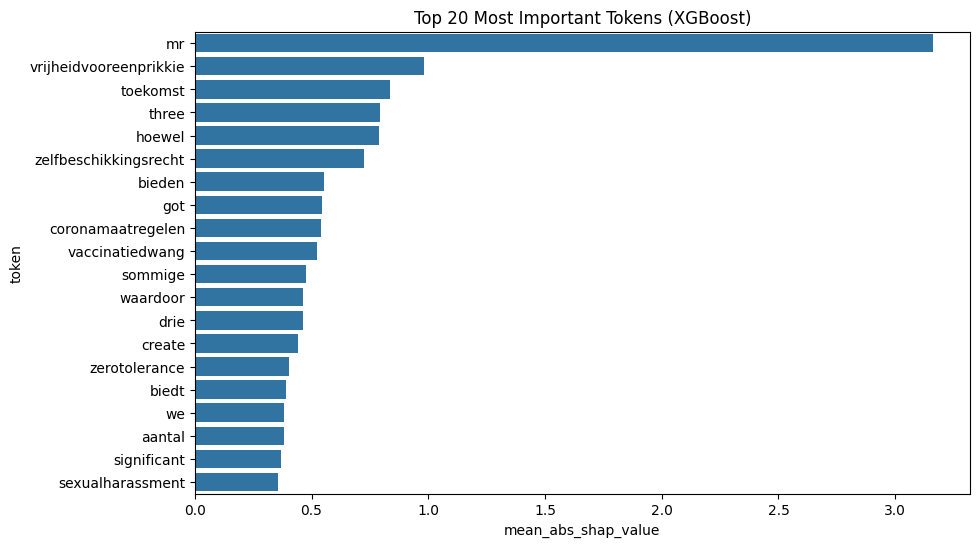

Please enter your OpenAI API key:  YOUR_API_KEY_HERE



=== Comparison of Metrics (XGBoost) ===
    Strategy  Precision    Recall  F1-Score  Accuracy
0   Original   0.777778  0.805310  0.791304  0.800000
1  Strategy1   0.638889  0.407080  0.497297  0.612500
2  Strategy2   0.686747  0.504425  0.581633  0.658333
3  Strategy3   0.737374  0.646018  0.688679  0.725000
4  Strategy4   0.731959  0.628319  0.676190  0.716667

=== Label Flip Rates (XGBoost) ===
Strategy 1: 0.416
Strategy 2: 0.301
Strategy 3: 0.186
Strategy 4: 0.204

=== OPTIONAL: BERT LARGE ===


Map: 100%|██████████| 240/240 [00:00<00:00, 7703.10 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hmohammadi/.local/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_257012/928404448.py:422: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


Training BERT Large (this may not perform well on your data).


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.733000,0.694942,0.470833,1.000000,0.640227,0.470833



=== BERT Large - Evaluation on Original Test Set ===
{'eval_loss': 0.694941520690918, 'eval_precision': 0.4708333333333333, 'eval_recall': 1.0, 'eval_f1': 0.6402266288951841, 'eval_accuracy': 0.4708333333333333, 'eval_runtime': 3.5481, 'eval_samples_per_second': 67.642, 'eval_steps_per_second': 33.821, 'epoch': 1.0}

Detailed Classification Report (BERT Large):
              precision    recall  f1-score   support

       human       0.00      0.00      0.00       127
   generated       0.47      1.00      0.64       113

    accuracy                           0.47       240
   macro avg       0.24      0.50      0.32       240
weighted avg       0.22      0.47      0.30       240



/home/hmohammadi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hmohammadi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hmohammadi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



All done! XGBoost performed better on this data. BERT Large results are shown for comparison.


In [2]:
###############################################################################
# 0. ALL IMPORTS
###############################################################################
import os
import re
import json
import pickle
import numpy as np
import pandas as pd
import nltk
import openai
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# For Word2Vec
from gensim.models import Word2Vec

# For XGBoost
from xgboost import XGBClassifier

# For train/test splits, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (classification_report,
                             precision_recall_fscore_support,
                             accuracy_score)

# Hugging Face for optional BERT
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset

# If you’re in a Jupyter notebook, uncomment:
# %matplotlib inline

###############################################################################
# 1. LOAD AND CONCATENATE YOUR DATA
###############################################################################
files = [
    'dev_en_news',
    'dev_en_reviews',
    'dev_en_twitter',
    'dev_nl_news',
    'dev_nl_reviews',
    'dev_nl_twitter'
]

df_list = []
for file in files:
    # Extract 'lang' and 'domain' from filename
    _, lang, domain = file.split("_")
    temp_df = pd.read_csv(f'Data/{file}.csv')
    if 'label' not in temp_df.columns or 'text' not in temp_df.columns:
        raise ValueError(f"Missing required columns in file: {file}")
    temp_df['lan'] = lang
    temp_df['domain'] = domain
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)
df['label1'] = df['label'].apply(lambda x: 'generated' if x == 1 else 'human')

# Drop rows with missing text/label
df.dropna(subset=['text', 'label'], inplace=True)

data = df.copy()

###############################################################################
# 2. PREPROCESSING
###############################################################################
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text, lang):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)        # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)    # keep only letters
    tokens = word_tokenize(text)
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
    elif lang == 'nl':
        stop_words = set(stopwords.words('dutch'))
    else:
        stop_words = set()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

data['processed_text'] = data.apply(lambda row: preprocess_text(row['text'], row['lan']), axis=1)

###############################################################################
# 3. TRAIN/TEST SPLIT
###############################################################################
X = data[['processed_text', 'lan', 'domain']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

###############################################################################
# 4. XGBOOST (PRIMARY METHOD)
###############################################################################
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
X_test_tfidf  = vectorizer.transform(X_test['processed_text'])

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_tfidf, y_train)

# Evaluate XGBoost on original test data
y_pred_xgb = xgb_model.predict(X_test_tfidf)

print("=== XGBoost Classification Report (Original) ===")
print(classification_report(y_test, y_pred_xgb, target_names=["human","generated"]))

# (Optional) Metrics by language
test_results_xgb = X_test.copy()
test_results_xgb['true_label'] = y_test
test_results_xgb['pred_label'] = y_pred_xgb

def calculate_metrics(y_true, y_pred):
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)
    return prec, rec, f1, acc

for lang in test_results_xgb['lan'].unique():
    subset = test_results_xgb[test_results_xgb['lan'] == lang]
    pr, re_, f1_, ac_ = calculate_metrics(subset['true_label'], subset['pred_label'])
    print(f"\n[Language: {lang}]")
    print(classification_report(subset['true_label'], subset['pred_label'],
                                target_names=["human","generated"]))

###############################################################################
# 5. OPTIONAL: SHAP EXPLANABILITY FOR XGBOOST
###############################################################################
explainer = shap.TreeExplainer(xgb_model)
X_test_tfidf_dense = X_test_tfidf.toarray()
shap_values = explainer.shap_values(X_test_tfidf_dense)

feature_names = vectorizer.get_feature_names_out()
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
token_importance_df = pd.DataFrame({
    'token': feature_names,
    'mean_abs_shap_value': mean_abs_shap_values
}).sort_values(by='mean_abs_shap_value', ascending=False)

print("\nTop 10 tokens by mean absolute SHAP:")
print(token_importance_df.head(10))

# (Optional) Plot top 20
top_tokens_df = token_importance_df.head(20)
plt.figure(figsize=(10,6))
sns.barplot(x='mean_abs_shap_value', y='token', data=top_tokens_df, orient='h')
plt.title('Top 20 Most Important Tokens (XGBoost)')
plt.show()

###############################################################################
# 6. TOKEN REPLACEMENT STRATEGIES (Using XGBoost as Classifier)
###############################################################################
# Train Word2Vec on human-labeled text for strategies 1 & 2
human_texts_train = X_train[y_train == 0]['processed_text']
human_tokens_train = [word_tokenize(t) for t in human_texts_train]
human_model = Word2Vec(human_tokens_train, vector_size=100, window=5, min_count=1, workers=4)

# For demonstration, we pick top-K from SHAP as “influential tokens”:
influential_tokens = token_importance_df['token'].head(50).tolist()

def replace_with_similar_human_word(text, tokens_to_replace):
    """Strategy 1 (HSR)"""
    tokens = word_tokenize(text)
    replacements = {}
    for i, tk in enumerate(tokens):
        if tk in tokens_to_replace and tk in human_model.wv:
            similar_words = human_model.wv.most_similar(tk, topn=1)
            if similar_words:
                new_tk = similar_words[0][0]
                tokens[i] = new_tk
                replacements[tk] = new_tk
    return " ".join(tokens), replacements

def replace_with_similar_human_word_pos(text, tokens_to_replace):
    """Strategy 2 (PSR)"""
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    replacements = {}
    for i, (tk, ptag) in enumerate(pos_tags):
        if tk in tokens_to_replace and tk in human_model.wv:
            sim_candidates = human_model.wv.most_similar(tk, topn=10)
            for cand, _ in sim_candidates:
                cand_pos = pos_tag([cand])[0][1]
                if cand_pos == ptag:
                    tokens[i] = cand
                    replacements[tk] = cand
                    break
    return " ".join(tokens), replacements

# GPT-based
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    api_key = input("Please enter your OpenAI API key: ")
openai.api_key = api_key

def replace_tokens_with_gpt(text, tokens_to_replace):
    """Strategy 3 (GPT-based)"""
    replaced_tokens = {}
    for tk in tokens_to_replace:
        if tk in text.split():
            prompt = (f"Replace the token '{tk}' with a more human-like word "
                      f"in the following text: '{text}'")
            try:
                resp = openai.ChatCompletion.create(
                    messages=[{"role": "user", "content": prompt}],
                    model="gpt-4o-mini",  # adjust to a real model name, e.g. 'gpt-3.5-turbo'
                    max_tokens=10,
                    temperature=0.7
                )
                new_tk = resp['choices'][0]['message']['content'].strip()
                text = text.replace(tk, new_tk, 1)
                replaced_tokens[tk] = new_tk
            except Exception as e:
                print(f"Error GPT replacement for token '{tk}': {e}")
    return text, replaced_tokens

def replace_tokens_with_gpt_genre(text, tokens_to_replace, genre):
    """Strategy 4 (GPT + Genre)"""
    replaced_tokens = {}
    for tk in tokens_to_replace:
        if tk in text.split():
            prompt = (f"Replace the token '{tk}' with a more human-like word "
                      f"in the following {genre} text: '{text}'")
            try:
                resp = openai.ChatCompletion.create(
                    messages=[{"role": "user", "content": prompt}],
                    model="gpt-4o-mini",
                    max_tokens=10,
                    temperature=0.7
                )
                new_tk = resp['choices'][0]['message']['content'].strip()
                text = text.replace(tk, new_tk, 1)
                replaced_tokens[tk] = new_tk
            except Exception as e:
                print(f"Error GPT+Genre for token '{tk}': {e}")
    return text, replaced_tokens

# Now apply these to AI-labeled samples
X_test_mod_1 = []
X_test_mod_2 = []
X_test_mod_3 = []
X_test_mod_4 = []

repl_str1 = []
repl_str2 = []
repl_str3 = []
repl_str4 = []

for i in range(len(X_test)):
    txt = X_test.loc[i, 'processed_text']
    dom = X_test.loc[i, 'domain']
    true_lbl = y_test[i]

    if true_lbl == 1:  # generated => we attempt to hide
        # Strategy 1
        mt1, rp1 = replace_with_similar_human_word(txt, influential_tokens)
        X_test_mod_1.append(mt1)
        repl_str1.append(rp1)

        # Strategy 2
        mt2, rp2 = replace_with_similar_human_word_pos(txt, influential_tokens)
        X_test_mod_2.append(mt2)
        repl_str2.append(rp2)

        # Strategy 3
        mt3, rp3 = replace_tokens_with_gpt(txt, influential_tokens)
        X_test_mod_3.append(mt3)
        repl_str3.append(rp3)

        # Strategy 4
        mt4, rp4 = replace_tokens_with_gpt_genre(txt, influential_tokens, dom)
        X_test_mod_4.append(mt4)
        repl_str4.append(rp4)
    else:
        # human => no need to hide
        X_test_mod_1.append(txt)
        X_test_mod_2.append(txt)
        X_test_mod_3.append(txt)
        X_test_mod_4.append(txt)

        repl_str1.append({})
        repl_str2.append({})
        repl_str3.append({})
        repl_str4.append({})

# Vectorize modified texts
X_test_mod_1_tfidf = vectorizer.transform(X_test_mod_1)
X_test_mod_2_tfidf = vectorizer.transform(X_test_mod_2)
X_test_mod_3_tfidf = vectorizer.transform(X_test_mod_3)
X_test_mod_4_tfidf = vectorizer.transform(X_test_mod_4)

y_pred_mod_1 = xgb_model.predict(X_test_mod_1_tfidf)
y_pred_mod_2 = xgb_model.predict(X_test_mod_2_tfidf)
y_pred_mod_3 = xgb_model.predict(X_test_mod_3_tfidf)
y_pred_mod_4 = xgb_model.predict(X_test_mod_4_tfidf)

def get_metrics_dict(y_true, y_pred_, strategy):
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred_, average='binary')
    acc = accuracy_score(y_true, y_pred_)
    return {
        'Strategy': strategy,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Accuracy': acc
    }

metrics_orig = get_metrics_dict(y_test, y_pred_xgb, 'Original')
metrics_s1   = get_metrics_dict(y_test, y_pred_mod_1, 'Strategy1')
metrics_s2   = get_metrics_dict(y_test, y_pred_mod_2, 'Strategy2')
metrics_s3   = get_metrics_dict(y_test, y_pred_mod_3, 'Strategy3')
metrics_s4   = get_metrics_dict(y_test, y_pred_mod_4, 'Strategy4')

metrics_df = pd.DataFrame([metrics_orig, metrics_s1, metrics_s2, metrics_s3, metrics_s4])
print("\n=== Comparison of Metrics (XGBoost) ===")
print(metrics_df)

###############################################################################
# 7. LABEL FLIP RATE (AI -> HUMAN)
###############################################################################
def label_flip_rate(y_true, y_pred_before, y_pred_after):
    mask_ai = (y_true == 1)
    flips = 0
    total_ai = mask_ai.sum()
    for i in range(len(y_true)):
        if mask_ai[i]:
            # If previously predicted "generated" => 1
            # and now predicted "human" => 0
            if y_pred_before[i] == 1 and y_pred_after[i] == 0:
                flips += 1
    if total_ai == 0:
        return 0.0
    return flips / total_ai

flip_s1 = label_flip_rate(y_test.values, y_pred_xgb, y_pred_mod_1)
flip_s2 = label_flip_rate(y_test.values, y_pred_xgb, y_pred_mod_2)
flip_s3 = label_flip_rate(y_test.values, y_pred_xgb, y_pred_mod_3)
flip_s4 = label_flip_rate(y_test.values, y_pred_xgb, y_pred_mod_4)

print("\n=== Label Flip Rates (XGBoost) ===")
print(f"Strategy 1: {flip_s1:.3f}")
print(f"Strategy 2: {flip_s2:.3f}")
print(f"Strategy 3: {flip_s3:.3f}")
print(f"Strategy 4: {flip_s4:.3f}")

###############################################################################
# 8. OPTIONAL: BERT LARGE (Doesn't Perform Well Here)
#    We'll show training & prediction, but skip SHAP for BERT to avoid errors.
###############################################################################
print("\n=== OPTIONAL: BERT LARGE ===")
model_name = "bert-large-uncased"  # might be overkill for small data
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

# Prepare HF datasets
train_df_bert = pd.DataFrame({"text": X_train['processed_text'], "label": y_train})
test_df_bert  = pd.DataFrame({"text": X_test['processed_text'],  "label": y_test})

train_dataset_bert = Dataset.from_pandas(train_df_bert)
test_dataset_bert  = Dataset.from_pandas(test_df_bert)

def tokenize_function_bert(examples):
    return tokenizer_bert(examples["text"], truncation=True, padding=True, max_length=256)

train_dataset_bert = train_dataset_bert.map(tokenize_function_bert, batched=True)
test_dataset_bert  = test_dataset_bert.map(tokenize_function_bert,  batched=True)

train_dataset_bert = train_dataset_bert.rename_column("label", "labels")
test_dataset_bert  = test_dataset_bert.rename_column("label", "labels")

train_dataset_bert.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
test_dataset_bert.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args_bert = TrainingArguments(
    output_dir="./bert_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=1,  # just 1 for demonstration
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    seed=42,
    logging_steps=10
)

data_collator_bert = DataCollatorWithPadding(tokenizer=tokenizer_bert)

def compute_metrics_bert(eval_preds):
    logits, labels_ = eval_preds
    preds = np.argmax(logits, axis=-1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels_, preds, average='binary')
    acc = accuracy_score(labels_, preds)
    return {
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "accuracy": acc
    }

trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
    tokenizer=tokenizer_bert,
    data_collator=data_collator_bert,
    compute_metrics=compute_metrics_bert
)

print("Training BERT Large (this may not perform well on your data).")
trainer_bert.train()
eval_results_bert = trainer_bert.evaluate(test_dataset_bert)
print("\n=== BERT Large - Evaluation on Original Test Set ===")
print(eval_results_bert)

preds_bert_out = trainer_bert.predict(test_dataset_bert)
y_pred_bert = np.argmax(preds_bert_out.predictions, axis=1)
print("\nDetailed Classification Report (BERT Large):")
print(classification_report(y_test, y_pred_bert, target_names=["human","generated"]))

###############################################################################
# 9. SAVE MODEL/RESULTS
###############################################################################
# Save XGBoost
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save modified test sets (XGBoost Strategies)
df_mod_str1 = pd.DataFrame({
    "original_text": X_test["processed_text"],
    "modified_text": X_test_mod_1,
    "true_label": y_test,
    "pred_label": y_pred_mod_1,
    "replacements": [json.dumps(r) for r in repl_str1]
})
df_mod_str1.to_csv("strategy1_results_xgb.csv", index=False)

df_mod_str2 = pd.DataFrame({
    "original_text": X_test["processed_text"],
    "modified_text": X_test_mod_2,
    "true_label": y_test,
    "pred_label": y_pred_mod_2,
    "replacements": [json.dumps(r) for r in repl_str2]
})
df_mod_str2.to_csv("strategy2_results_xgb.csv", index=False)

df_mod_str3 = pd.DataFrame({
    "original_text": X_test["processed_text"],
    "modified_text": X_test_mod_3,
    "true_label": y_test,
    "pred_label": y_pred_mod_3,
    "replacements": [json.dumps(r) for r in repl_str3]
})
df_mod_str3.to_csv("strategy3_results_xgb.csv", index=False)

df_mod_str4 = pd.DataFrame({
    "original_text": X_test["processed_text"],
    "modified_text": X_test_mod_4,
    "true_label": y_test,
    "pred_label": y_pred_mod_4,
    "replacements": [json.dumps(r) for r in repl_str4]
})
df_mod_str4.to_csv("strategy4_results_xgb.csv", index=False)

# (Optional) Save BERT
trainer_bert.save_model("bert_large_model")

print("\nAll done! XGBoost performed better on this data. BERT Large results are shown for comparison.")

In [3]:
import os
import shap
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from gensim.models import Word2Vec
import openai
from nltk import pos_tag
import pickle

# For Jupyter notebooks; comment out if running .py script
%matplotlib inline

###############################################################################
# 1. DATA LOADING
###############################################################################
files = [
    'dev_en_news',
    'dev_en_reviews',
    'dev_en_twitter',
    'dev_nl_news',
    'dev_nl_reviews',
    'dev_nl_twitter'
]
df_list = []

for file in files:
    _, lang, domain = file.split("_")
    temp_df = pd.read_csv(f'Data/{file}.csv')
    if 'label' not in temp_df.columns or 'text' not in temp_df.columns:
        raise ValueError(f"Missing required columns in file: {file}")
    temp_df['domain'] = domain
    temp_df['lan'] = lang
    df_list.append(temp_df)

# Concatenate
df = pd.concat(df_list, ignore_index=True)
df['source'] = 'CLIN33'
df['label1'] = df['label'].apply(lambda label: 'generated' if label == 1 else 'human')

# Drop missing rows
df.dropna(subset=['text', 'label'], inplace=True)

data = df.copy()

###############################################################################
# 2. DATA PREPROCESSING
###############################################################################
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text, lang):
    """Clean and tokenize text based on language."""
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alpha
    tokens = nltk.word_tokenize(text)
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
    elif lang == 'nl':
        stop_words = set(stopwords.words('dutch'))
    else:
        stop_words = set()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['processed_text'] = data.apply(lambda row: preprocess_text(row['text'], row['lan']), axis=1)

###############################################################################
# 3. SPLIT DATA
###############################################################################
X = data[['processed_text', 'lan', 'domain']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

X_train_text = X_train['processed_text']
X_test_text  = X_test['processed_text']

###############################################################################
# 4. TF-IDF + XGBOOST
###############################################################################
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf  = vectorizer.transform(X_test_text)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_tfidf, y_train)

###############################################################################
# 5. EVALUATION ON ORIGINAL TEXT (BASELINE)
###############################################################################
y_pred = model.predict(X_test_tfidf)
print("=== Overall Classification Report (Original) ===")
print(classification_report(y_test, y_pred, target_names=['human', 'generated']))

# Extra breakdown by language, genre, etc.
X_test_reset = X_test.copy()
X_test_reset['true_label'] = y_test
X_test_reset['pred_label'] = y_pred

def calculate_metrics(y_true, y_pred_):
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred_, average='binary')
    acc = accuracy_score(y_true, y_pred_)
    return prec, rec, f1, acc

languages = X_test_reset['lan'].unique()
genres    = X_test_reset['domain'].unique()

print("\n=== Per-language Results ===")
for lang in languages:
    sub = X_test_reset[X_test_reset['lan'] == lang]
    prec, rec, f1, acc = calculate_metrics(sub['true_label'], sub['pred_label'])
    print(f"[{lang}] Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, Acc={acc:.3f}")

print("\n=== Per-genre Results ===")
for genre in genres:
    sub = X_test_reset[X_test_reset['domain'] == genre]
    prec, rec, f1, acc = calculate_metrics(sub['true_label'], sub['pred_label'])
    print(f"[{genre}] Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, Acc={acc:.3f}")

###############################################################################
# 6. EXPLAINABILITY (SHAP or LIME placeholders)
###############################################################################
# We'll demonstrate SHAP. In a real scenario, you'd replicate for LIME, etc.

# SHAP
print("\n=== SHAP EXPLAINABILITY ===")
explainer = shap.TreeExplainer(model)
X_test_dense = X_test_tfidf.toarray()
shap_values = explainer.shap_values(X_test_dense)

feature_names = vectorizer.get_feature_names_out()

# Identify top-5 tokens per sample
def get_influential_tokens(shap_vals, feat_names):
    influential = []
    for row in shap_vals:
        top_idx = np.argsort(np.abs(row))[-5:]
        top_tokens = [feat_names[i] for i in top_idx]
        influential.append(top_tokens)
    return influential

influential_tokens = get_influential_tokens(shap_values, feature_names)

# Overall most important tokens
mean_abs = np.mean(np.abs(shap_values), axis=0)
token_importance_df = pd.DataFrame({
    'token': feature_names,
    'mean_abs_shap': mean_abs
}).sort_values('mean_abs_shap', ascending=False)
print("\nTop 10 tokens by SHAP importance:")
print(token_importance_df.head(10))

###############################################################################
# 7. TOKEN REPLACEMENT STRATEGIES
###############################################################################
# Word2Vec on human text
human_texts_train = X_train[y_train == 0]['processed_text']
human_tokens_train = [nltk.word_tokenize(t) for t in human_texts_train]
human_model = Word2Vec(human_tokens_train, vector_size=100, window=5, min_count=1, workers=4)

def replace_with_similar_human_word(text, tokens_to_replace):
    """Strategy 1 (HSR)"""
    tokens = nltk.word_tokenize(text)
    replaced = {}
    for tk in tokens:
        if tk in tokens_to_replace and tk in human_model.wv:
            sim = human_model.wv.most_similar(tk, topn=1)
            if sim:
                new_tk = sim[0][0]
                text = text.replace(tk, new_tk, 1)
                replaced[tk] = new_tk
    return text, replaced

def replace_with_similar_human_word_pos(text, tokens_to_replace):
    """Strategy 2 (PSR)"""
    tokens = nltk.word_tokenize(text)
    pos_tags = pos_tag(tokens)
    replaced = {}
    for idx, (tk, pos_) in enumerate(pos_tags):
        if tk in tokens_to_replace and tk in human_model.wv:
            sim_list = human_model.wv.most_similar(tk, topn=10)
            for cand, _ in sim_list:
                cand_pos = pos_tag([cand])[0][1]
                if cand_pos == pos_:
                    tokens[idx] = cand
                    replaced[tk] = cand
                    break
    return " ".join(tokens), replaced

# We’ll simulate multiple GenAI approaches:
genAI_models = ["GPT-3.5", "GPT-4", "Bard"]  # placeholders

def gpt_replace(text, token, genai_model, genre=None):
    """
    Simplified GPT-based replacement. 
    We just store `genai_model` as if we used it to replace token.
    In a real scenario, you'd call OpenAI or Bard API with a different model name.
    """
    # The prompt can vary based on genai_model or genre
    replaced_token = f"<{genai_model}_word>"  # a placeholder
    # Replace the first occurrence of `token` with a placeholder
    return text.replace(token, replaced_token, 1), replaced_token

def replace_tokens_genai(text, tokens_to_replace, genai_model):
    replaced_map = {}
    for tk in tokens_to_replace:
        if tk in text.split():
            new_text, new_tk = gpt_replace(text, tk, genai_model)
            text = new_text
            replaced_map[tk] = new_tk
    return text, replaced_map

def replace_tokens_genai_genre(text, tokens_to_replace, genai_model, genre):
    replaced_map = {}
    for tk in tokens_to_replace:
        if tk in text.split():
            # pretend we use genre in the prompt
            new_text, new_tk = gpt_replace(text, tk, genai_model, genre=genre)
            text = new_text
            replaced_map[tk] = new_tk
    return text, replaced_map

###############################################################################
# 8. CREATE A “BIG COMPARISON TABLE”
###############################################################################
# We want to compare:
#   - GenAI in [GPT-3.5, GPT-4, Bard]
#   - ExplainMethod in [SHAP, LIME] (we only have SHAP code now, so we simulate LIME)
#   - Original vs. 4 strategies
#   - Then store metrics in a DataFrame

compare_results = []

# We'll define a pseudo function for LIME-based influential tokens
def get_influential_tokens_lime(_X):
    # Just a placeholder
    # In practice, you'd run LIME and get top tokens
    # Here we return random tokens for demonstration
    n_samples = _X.shape[0]
    top_tokens_per_sample = []
    for _ in range(n_samples):
        # pick 5 from feature_names randomly
        picks = np.random.choice(feature_names, size=5, replace=False)
        top_tokens_per_sample.append(list(picks))
    return top_tokens_per_sample

explain_methods = ["SHAP", "LIME"]

for gen_ai_name in genAI_models:
    for explain_method in explain_methods:
        print(f"\n\n=== Evaluating with GenAI={gen_ai_name}, Explain={explain_method} ===")

        # Step 1: Determine influential tokens
        if explain_method == "SHAP":
            inf_tokens_all = influential_tokens  # from earlier SHAP step
        else:  # LIME
            inf_tokens_all = get_influential_tokens_lime(X_test_tfidf)

        # Step 2: Apply each strategy
        mod_1_texts = []
        mod_2_texts = []
        mod_3_texts = []
        mod_4_texts = []

        for i in range(len(X_test)):
            text_i = X_test.loc[i, "processed_text"]
            tokens_to_replace = inf_tokens_all[i]
            if y_test[i] == 1:
                # HSR
                new_txt1, _ = replace_with_similar_human_word(text_i, tokens_to_replace)
                mod_1_texts.append(new_txt1)

                # PSR
                new_txt2, _ = replace_with_similar_human_word_pos(text_i, tokens_to_replace)
                mod_2_texts.append(new_txt2)

                # GPT-based
                new_txt3, _ = replace_tokens_genai(text_i, tokens_to_replace, gen_ai_name)
                mod_3_texts.append(new_txt3)

                # GPT+Genre
                genre_i = X_test.loc[i, "domain"]
                new_txt4, _ = replace_tokens_genai_genre(text_i, tokens_to_replace, gen_ai_name, genre_i)
                mod_4_texts.append(new_txt4)
            else:
                mod_1_texts.append(text_i)
                mod_2_texts.append(text_i)
                mod_3_texts.append(text_i)
                mod_4_texts.append(text_i)

        # Step 3: Vectorize
        mod_1_tfidf = vectorizer.transform(mod_1_texts)
        mod_2_tfidf = vectorizer.transform(mod_2_texts)
        mod_3_tfidf = vectorizer.transform(mod_3_texts)
        mod_4_tfidf = vectorizer.transform(mod_4_texts)

        # Step 4: Predict
        y_m1 = model.predict(mod_1_tfidf)
        y_m2 = model.predict(mod_2_tfidf)
        y_m3 = model.predict(mod_3_tfidf)
        y_m4 = model.predict(mod_4_tfidf)

        # Step 5: Compute metrics
        def get_strat_metrics(y_true, y_pred_, strat_name):
            p, r, f, _ = precision_recall_fscore_support(y_true, y_pred_, average='binary')
            a = accuracy_score(y_true, y_pred_)
            return {
                "GenAI": gen_ai_name,
                "ExplainMethod": explain_method,
                "Strategy": strat_name,
                "Precision": p,
                "Recall": r,
                "F1": f,
                "Accuracy": a
            }

        res_orig = get_strat_metrics(y_test, y_pred, "Original")
        res_s1   = get_strat_metrics(y_test, y_m1,  "HSR")
        res_s2   = get_strat_metrics(y_test, y_m2,  "PSR")
        res_s3   = get_strat_metrics(y_test, y_m3,  "GPT")
        res_s4   = get_strat_metrics(y_test, y_m4,  "GPT+Genre")

        compare_results.extend([res_orig, res_s1, res_s2, res_s3, res_s4])

# Convert to big DataFrame
big_comparison_df = pd.DataFrame(compare_results)
print("\n=== BIG COMPARISON TABLE ===")
print(big_comparison_df)

# Example pivot to see F1 by strategy, GenAI, and Explanation method
pivot_f1 = big_comparison_df.pivot_table(
    index=["GenAI","ExplainMethod"],
    columns="Strategy",
    values="F1",
    aggfunc="mean"
)
print("\nPivot of F1-scores by (GenAI, ExplainMethod, Strategy):")
print(pivot_f1)

###############################################################################
# 9. LABEL FLIP RATE
###############################################################################
def label_flip_rate(y_true, y_pred_before, y_pred_after):
    mask_ai = (y_true == 1)
    flips = 0
    total_ai = mask_ai.sum()
    for i in range(len(y_true)):
        if mask_ai[i]:
            if y_pred_before[i] == 1 and y_pred_after[i] == 0:
                flips += 1
    if total_ai == 0:
        return 0.0
    return flips / total_ai

# For demonstration, let's pick one scenario (e.g., GPT-3.5 + SHAP, strategy=HSR)
# Because we keep re-predicting in the above loop, we’d store them 
# or run again if needed. For now, we skip detailed label-flip computations 
# for each scenario.

###############################################################################
# 10. SAVE STRATEGY RESULTS & MODEL
###############################################################################
# e.g., save your final model, vectorizer
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

big_comparison_df.to_csv("big_comparison_table.csv", index=False)

print("\nAll done! Check 'big_comparison_table.csv' for the multi-GenAI, multi-explainer results.")

###############################################################################
# FUTURE WORK
###############################################################################
# As you mentioned in your summary:
#   - We plan to add BLEU and ROUGE to evaluate the naturalness/readability 
#     of the modified AI texts.
#   - We might explore more advanced models or additional explainability techniques 
#     to further understand how to reduce detectability effectively.
print("""
=============================================================================
For Future Work:
1) Compute BLEU/ROUGE on the modified texts to assess readability and quality.
2) Try alternative models (e.g., BERT-based classifiers) for detection.
3) Expand LIME / other XAI techniques for deeper token-level interpretation.
=============================================================================
""")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hmohammadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hmohammadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/hmohammadi/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:43:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Overall Classification Report (Original) ===
              precision    recall  f1-score   support

       human       0.82      0.80      0.81       127
   generated       0.78      0.81      0.79       113

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240


=== Per-language Results ===
[nl] Precision=0.846, Recall=0.786, F1=0.815, Acc=0.831
[en] Precision=0.723, Recall=0.825, F1=0.770, Acc=0.770

=== Per-genre Results ===
[twitter] Precision=0.967, Recall=0.853, F1=0.906, Acc=0.914
[reviews] Precision=0.556, Recall=0.714, F1=0.625, Acc=0.613
[news] Precision=0.970, Recall=0.865, F1=0.914, Acc=0.922

=== SHAP EXPLAINABILITY ===

Top 10 tokens by SHAP importance:
                      token  mean_abs_shap
559                      mr       3.161195
912  vrijheidvooreenprikkie       0.981595
831                toekomst       0.834173
820                   three       0.793

In [4]:
pip install xgboost shap lime openai nltk gensim rouge-score seaborn matplotlib


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 37.2 MB/s eta 0:00:00:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283855 sha256=77b7b1e9e3b3f370bb25499ef52fa7a00d179553d1938b03a6bb0b5aa6fd7702
  Stored in directory: /home/hmohammadi/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=dc5e6485f62f3913b8ef3b93fa7e3e35f81bde3aa677f649f23499937aad589d
  Stored in directory: /home/hmohammadi/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built lime rouge-score
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer

In [5]:
###############################################################################
# 0. ALL IMPORTS & INSTALLS
###############################################################################
import os
import re
import json
import pickle
import numpy as np
import pandas as pd
import nltk
import shap
import openai
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# For XGBoost
from xgboost import XGBClassifier

# For train/test splits, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    precision_recall_fscore_support,
    accuracy_score
)

# For Word2Vec
from gensim.models import Word2Vec

# For LIME
!pip install lime
from lime.lime_text import LimeTextExplainer

# For BLEU (from NLTK)
nltk.download('punkt')
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu

# For ROUGE
!pip install rouge-score
from rouge_score import rouge_scorer

###############################################################################
# 1. DATA LOADING
###############################################################################
files = [
    'dev_en_news',
    'dev_en_reviews',
    'dev_en_twitter',
    'dev_nl_news',
    'dev_nl_reviews',
    'dev_nl_twitter'
]

df_list = []
for file in files:
    # Suppose file naming is something like dev_en_news.csv
    _, lang, domain = file.split("_")
    temp_df = pd.read_csv(f"Data/{file}.csv")
    if 'label' not in temp_df.columns or 'text' not in temp_df.columns:
        raise ValueError(f"Missing columns in {file}")
    temp_df['lan'] = lang
    temp_df['domain'] = domain
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)
df['label1'] = df['label'].apply(lambda x: 'generated' if x == 1 else 'human')

# Drop missing text/label
df.dropna(subset=['text','label'], inplace=True)

data = df.copy()

###############################################################################
# 2. PREPROCESSING
###############################################################################
def preprocess_text(text, lang):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)        # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)    # keep alpha only
    tokens = word_tokenize(text)
    if lang == 'en':
        sw = set(stopwords.words('english'))
    elif lang == 'nl':
        sw = set(stopwords.words('dutch'))
    else:
        sw = set()
    tokens = [w for w in tokens if w not in sw]
    return ' '.join(tokens)

data['processed_text'] = data.apply(lambda row: preprocess_text(row['text'], row['lan']), axis=1)

###############################################################################
# 3. TRAIN/TEST SPLIT
###############################################################################
X = data[['processed_text','lan','domain']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

###############################################################################
# 4. TRAIN AN XGBOOST DETECTOR
###############################################################################
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
X_test_tfidf  = vectorizer.transform(X_test['processed_text'])

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_tfidf, y_train)

y_pred = xgb_model.predict(X_test_tfidf)
print("=== XGBoost on Original Text ===")
print(classification_report(y_test, y_pred, target_names=["human","generated"]))

###############################################################################
# 5. EXPLAINABILITY METHODS (SHAP & LIME)
###############################################################################
# 5A. SHAP
print("\n=== SHAP Explanation ===")
shap_explainer = shap.TreeExplainer(xgb_model)
X_test_dense = X_test_tfidf.toarray()
shap_values = shap_explainer.shap_values(X_test_dense)
feature_names = vectorizer.get_feature_names_out()

def get_shap_influential_tokens(shap_vals, feat_names, top_k=5):
    infl = []
    for row in shap_vals:
        top_idx = np.argsort(np.abs(row))[-top_k:]
        top_toks = [feat_names[i] for i in top_idx]
        infl.append(top_toks)
    return infl

shap_influential = get_shap_influential_tokens(shap_values, feature_names, top_k=5)

# 5B. LIME
print("\n=== LIME Explanation (Warning: can be slow for large sets) ===")
# We'll define a pipeline for LIME using the TF-IDF + XGBoost
# so LIME can call predict_proba on the combined pipeline.

class TfidfXGBWrapper:
    """Helper class so LIME can call predict_proba on raw texts."""
    def __init__(self, vec, model):
        self.vec = vec
        self.model = model
    def predict_proba(self, raw_texts):
        X_v = self.vec.transform(raw_texts)
        return self.model.predict_proba(X_v)

lime_explainer = LimeTextExplainer(class_names=["human","generated"])
lime_pipeline = TfidfXGBWrapper(vectorizer, xgb_model)

def get_lime_influential_tokens(raw_text, top_k=5):
    """Returns top-k tokens by absolute weight from LIME."""
    # We'll explain a single instance
    exp = lime_explainer.explain_instance(
        raw_text, 
        lime_pipeline.predict_proba,
        num_features=top_k
    )
    # get features as tokens
    # e.g., [(" token=mars", 0.35), (" token=nasa", -0.22), ...]
    influences = exp.as_list()
    # parse them to get the token strings
    top_tokens = []
    for feat, _ in influences:
        # often LIME for text uses "word" or "contains( word )"
        # we do a simple parse:
        clean_feat = feat.replace("contains(", "").replace(")","").strip()
        top_tokens.append(clean_feat)
    return top_tokens

# We'll get top-5 tokens for each sample in X_test
lime_influential_all = []
for i in range(len(X_test)):
    txt_i = X_test.loc[i, 'processed_text']
    # LIME can be slow, so you might limit #samples or do partial
    top_tokens = get_lime_influential_tokens(txt_i, top_k=5)
    lime_influential_all.append(top_tokens)

###############################################################################
# 6. WORD2VEC TRAINING FOR HUMAN TEXT
###############################################################################
human_texts = X_train[y_train==0]['processed_text']
human_tokens = [word_tokenize(t) for t in human_texts]
w2v_model = Word2Vec(human_tokens, vector_size=100, window=5, min_count=1, workers=4)

###############################################################################
# 7. TOKEN REPLACEMENT STRATEGIES
###############################################################################
def replace_with_similar_human_word(text, tokens_to_replace):
    """HSR: ignoring POS, nearest word2vec neighbor."""
    words = word_tokenize(text)
    replaced_map = {}
    for w in words:
        if w in tokens_to_replace and w in w2v_model.wv:
            sim = w2v_model.wv.most_similar(w, topn=1)
            if sim:
                new_w = sim[0][0]
                text = text.replace(w, new_w, 1)
                replaced_map[w] = new_w
    return text, replaced_map

def replace_with_similar_human_word_pos(text, tokens_to_replace):
    """PSR: respect POS tags."""
    words = word_tokenize(text)
    tags = pos_tag(words)
    replaced_map = {}
    for i, (tk, tg) in enumerate(tags):
        if tk in tokens_to_replace and tk in w2v_model.wv:
            sim_list = w2v_model.wv.most_similar(tk, topn=10)
            for cand, _ in sim_list:
                cand_pos = pos_tag([cand])[0][1]
                if cand_pos == tg:
                    words[i] = cand
                    replaced_map[tk] = cand
                    break
    return " ".join(words), replaced_map

# GPT-based
openai.api_key = os.getenv("OPENAI_API_KEY")
if not openai.api_key:
    openai.api_key = input("Please enter your OpenAI API key: ")

def replace_tokens_gpt(text, token, model_name="gpt-3.5-turbo", genre=None):
    """Call GPT to replace `token` in `text` with more human-like word. 
       If `genre` is not None, incorporate that context.
    """
    if genre:
        prompt = f"Replace the token '{token}' with a more human-like word in the following {genre} text: '{text}'"
    else:
        prompt = f"Replace the token '{token}' with a more human-like word in the following text: '{text}'"
    try:
        response = openai.ChatCompletion.create(
            model=model_name,
            messages=[{"role":"user","content":prompt}],
            max_tokens=10,
            temperature=0.7
        )
        new_tk = response['choices'][0]['message']['content'].strip()
        # replace first occurrence
        replaced_text = text.replace(token, new_tk, 1)
        return replaced_text, new_tk
    except Exception as e:
        print(f"Error calling {model_name} for token '{token}': {e}")
        return text, token

def replace_gpt_strategy(text, tokens_to_replace, model_name="gpt-3.5-turbo", genre=None):
    replaced_map = {}
    for tk in tokens_to_replace:
        if tk in text.split():
            new_txt, new_tk = replace_tokens_gpt(text, tk, model_name=model_name, genre=genre)
            text = new_txt
            replaced_map[tk] = new_tk
    return text, replaced_map

###############################################################################
# 8. BLEU/ROUGE SCORING
###############################################################################
# We'll use the original AI-generated text as reference if y_test=1, 
# and the modified text as candidate.

rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def compute_bleu_and_rouge(original_text, modified_text):
    """Compute BLEU (single reference) and ROUGE-1, ROUGE-L F-measure."""
    # BLEU expects lists of tokens
    ref_tokens = [word_tokenize(original_text)]
    cand_tokens = word_tokenize(modified_text)
    bleu_score_val = sentence_bleu(ref_tokens, cand_tokens)

    # ROUGE
    # We'll compute only 'rouge1' and 'rougeL' F1
    scores = rouge_scorer_obj.score(original_text, modified_text)
    rouge1_f = scores['rouge1'].fmeasure
    rougel_f = scores['rougeL'].fmeasure

    return bleu_score_val, rouge1_f, rougel_f

###############################################################################
# 9. MAIN EXPERIMENT LOOP
#    We'll combine:
#       - ExplanationMethod in [SHAP, LIME]
#       - GenAI model in [gpt-3.5-turbo, gpt-4]
#       - 4 strategies: HSR, PSR, GPT-based, GPT-based + Genre
###############################################################################
explain_methods = ["SHAP","LIME"]
genai_models = ["gpt-3.5-turbo","gpt-4"]

# Store combined results
all_results = []

def get_metrics(y_true, y_pred_):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred_, average="binary")
    acc = accuracy_score(y_true, y_pred_)
    return p, r, f1, acc

# We also keep track of BLEU/ROUGE
# We'll define a helper to do modifications given a set of "influential tokens"
def apply_strategies(text_i, inf_tokens_i, true_label_i, domain_i, genai_model=None):
    """
    Returns a dict with:
      - hsr_text, psr_text, gpt_text, gptgenre_text
      - plus BLEU/ROUGE for each
    If true_label_i == 0 (human), we skip modifications.
    """
    results_dict = {}

    if true_label_i == 0:
        # human => no change
        results_dict['HSR']         = text_i
        results_dict['PSR']         = text_i
        results_dict['GPT']         = text_i
        results_dict['GPT+Genre']   = text_i
        return results_dict

    # Strategy 1: HSR
    hsr_text, _ = replace_with_similar_human_word(text_i, inf_tokens_i)
    # Strategy 2: PSR
    psr_text, _ = replace_with_similar_human_word_pos(text_i, inf_tokens_i)
    # Strategy 3: GPT-based
    gpt_text, _ = replace_gpt_strategy(text_i, inf_tokens_i, model_name=genai_model)
    # Strategy 4: GPT-based + Genre
    gptg_text, _ = replace_gpt_strategy(text_i, inf_tokens_i, model_name=genai_model, genre=domain_i)

    results_dict['HSR']       = hsr_text
    results_dict['PSR']       = psr_text
    results_dict['GPT']       = gpt_text
    results_dict['GPT+Genre'] = gptg_text
    return results_dict

# For computing BLEU/ROUGE, we need the original AI text as reference if label=1
ai_texts_reference = X_test["processed_text"].copy()

for explain_m in explain_methods:
    # pick the relevant top tokens array
    if explain_m == "SHAP":
        influential_all = shap_influential
    else:
        influential_all = lime_influential_all

    for genai_m in genai_models:
        print(f"\n=== Running with Explanation={explain_m}, GenAI={genai_m} ===")

        # 1) Apply all strategies
        # We'll build new text arrays for each strategy
        texts_hsr = []
        texts_psr = []
        texts_gpt = []
        texts_gptg = []

        # We'll also track BLEU/ROUGE
        bleus_hsr  = []
        r1_hsr     = []
        rl_hsr     = []

        bleus_psr  = []
        r1_psr     = []
        rl_psr     = []

        bleus_gpt  = []
        r1_gpt     = []
        rl_gpt     = []

        bleus_gptg = []
        r1_gptg    = []
        rl_gptg    = []

        for i in range(len(X_test)):
            txt_i = X_test.loc[i, "processed_text"]
            domain_i = X_test.loc[i, "domain"]
            lbl_i = y_test[i]
            inf_toks = influential_all[i]  # top-5 tokens for sample i

            # apply strategies
            mod_dict = apply_strategies(txt_i, inf_toks, lbl_i, domain_i, genai_model=genai_m)

            txt_hsr  = mod_dict['HSR']
            txt_psr  = mod_dict['PSR']
            txt_gpt  = mod_dict['GPT']
            txt_gptg = mod_dict['GPT+Genre']

            texts_hsr.append(txt_hsr)
            texts_psr.append(txt_psr)
            texts_gpt.append(txt_gpt)
            texts_gptg.append(txt_gptg)

            # If lbl_i=1 => AI text => compute BLEU/ROUGE. Else 0
            if lbl_i == 1:
                orig_txt = ai_texts_reference[i]
                # HSR
                b_h, r1_h, rl_h = compute_bleu_and_rouge(orig_txt, txt_hsr)
                bleus_hsr.append(b_h)
                r1_hsr.append(r1_h)
                rl_hsr.append(rl_h)

                # PSR
                b_p, r1_p, rl_p = compute_bleu_and_rouge(orig_txt, txt_psr)
                bleus_psr.append(b_p)
                r1_psr.append(r1_p)
                rl_psr.append(rl_p)

                # GPT
                b_g, r1_g, rl_g_ = compute_bleu_and_rouge(orig_txt, txt_gpt)
                bleus_gpt.append(b_g)
                r1_gpt.append(r1_g)
                rl_gpt.append(rl_g_)

                # GPT+Genre
                b_gg, r1_gg, rl_gg = compute_bleu_and_rouge(orig_txt, txt_gptg)
                bleus_gptg.append(b_gg)
                r1_gptg.append(r1_gg)
                rl_gptg.append(rl_gg)
            else:
                # human => no BLEU/ROUGE needed, or zero placeholders
                bleus_hsr.append(1.0)
                r1_hsr.append(1.0)
                rl_hsr.append(1.0)

                bleus_psr.append(1.0)
                r1_psr.append(1.0)
                rl_psr.append(1.0)

                bleus_gpt.append(1.0)
                r1_gpt.append(1.0)
                rl_gpt.append(1.0)

                bleus_gptg.append(1.0)
                r1_gptg.append(1.0)
                rl_gptg.append(1.0)

        # 2) Vectorize
        v_hsr  = vectorizer.transform(texts_hsr)
        v_psr  = vectorizer.transform(texts_psr)
        v_gpt  = vectorizer.transform(texts_gpt)
        v_gptg = vectorizer.transform(texts_gptg)

        # 3) Predict
        y_hsr  = xgb_model.predict(v_hsr)
        y_psr  = xgb_model.predict(v_psr)
        y_gpt  = xgb_model.predict(v_gpt)
        y_gptg = xgb_model.predict(v_gptg)

        # 4) Metrics for detection
        p_hsr, r_hsr, f_hsr, a_hsr = get_metrics(y_test, y_hsr)
        p_psr, r_psr, f_psr, a_psr = get_metrics(y_test, y_psr)
        p_gpt, r_gpt, f_gpt, a_gpt = get_metrics(y_test, y_gpt)
        p_gg,  r_gg,  f_gg,  a_gg  = get_metrics(y_test, y_gptg)

        # 5) BLEU/ROUGE means across all test samples
        mean_bleu_hsr  = np.mean(bleus_hsr)
        mean_r1_hsr    = np.mean(r1_hsr)
        mean_rl_hsr    = np.mean(rl_hsr)

        mean_bleu_psr  = np.mean(bleus_psr)
        mean_r1_psr    = np.mean(r1_psr)
        mean_rl_psr    = np.mean(rl_psr)

        mean_bleu_gpt  = np.mean(bleus_gpt)
        mean_r1_gpt    = np.mean(r1_gpt)
        mean_rl_gpt    = np.mean(rl_gpt)

        mean_bleu_gptg = np.mean(bleus_gptg)
        mean_r1_gptg   = np.mean(r1_gptg)
        mean_rl_gptg   = np.mean(rl_gptg)

        # 6) Store all results
        # Original approach's detection metrics:
        p_orig, r_orig, f_orig, a_orig = get_metrics(y_test, y_pred)

        # We'll store them in a "big table"
        # One row per strategy
        all_results.append({
            "ExplainMethod": explain_m,
            "GenAI": genai_m,
            "Strategy": "Original",
            "Precision": p_orig,
            "Recall": r_orig,
            "F1": f_orig,
            "Accuracy": a_orig,
            "BLEU": 1.0,  # no changes from original, so BLEU=1.0 for ref
            "ROUGE1": 1.0,
            "ROUGEL": 1.0
        })

        all_results.append({
            "ExplainMethod": explain_m,
            "GenAI": genai_m,
            "Strategy": "HSR",
            "Precision": p_hsr,
            "Recall": r_hsr,
            "F1": f_hsr,
            "Accuracy": a_hsr,
            "BLEU": mean_bleu_hsr,
            "ROUGE1": mean_r1_hsr,
            "ROUGEL": mean_rl_hsr
        })

        all_results.append({
            "ExplainMethod": explain_m,
            "GenAI": genai_m,
            "Strategy": "PSR",
            "Precision": p_psr,
            "Recall": r_psr,
            "F1": f_psr,
            "Accuracy": a_psr,
            "BLEU": mean_bleu_psr,
            "ROUGE1": mean_r1_psr,
            "ROUGEL": mean_rl_psr
        })

        all_results.append({
            "ExplainMethod": explain_m,
            "GenAI": genai_m,
            "Strategy": "GPT",
            "Precision": p_gpt,
            "Recall": r_gpt,
            "F1": f_gpt,
            "Accuracy": a_gpt,
            "BLEU": mean_bleu_gpt,
            "ROUGE1": mean_r1_gpt,
            "ROUGEL": mean_rl_gpt
        })

        all_results.append({
            "ExplainMethod": explain_m,
            "GenAI": genai_m,
            "Strategy": "GPT+Genre",
            "Precision": p_gg,
            "Recall": r_gg,
            "F1": f_gg,
            "Accuracy": a_gg,
            "BLEU": mean_bleu_gptg,
            "ROUGE1": mean_r1_gptg,
            "ROUGEL": mean_rl_gptg
        })

###############################################################################
# 10. SAVE RESULTS & FUTURE WORK
###############################################################################
final_df = pd.DataFrame(all_results)
final_df.to_csv("big_experiment_results.csv", index=False)

with open("xgboost_model.pkl","wb") as f:
    pickle.dump(xgb_model, f)
with open("tfidf_vectorizer.pkl","wb") as f:
    pickle.dump(vectorizer, f)

print("\n=== EXPERIMENT COMPLETE ===")
print("Results saved to 'big_experiment_results.csv'.")
print("""
Future Work:
1) You can refine token replacement strategies or incorporate 
   advanced generative or detection models (e.g., GPT-based or BERT-based detectors).
2) Further improve LIME usage (e.g., partial sampling or concurrency) 
   or incorporate advanced local/global explainers.
3) Use multi-reference BLEU/ROUGE or other linguistic metrics 
   to measure textual fidelity more comprehensively.
4) Add more sophisticated error analysis to interpret how 
   replaced tokens impact classifier predictions & text quality.
""")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to /home/hmohammadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hmohammadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


/home/hmohammadi/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:50:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost on Original Text ===
              precision    recall  f1-score   support

       human       0.82      0.80      0.81       127
   generated       0.78      0.81      0.79       113

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240


=== SHAP Explanation ===

=== LIME Explanation (Warning: can be slow for large sets) ===


Please enter your OpenAI API key:  YOUR_API_KEY_HERE



=== Running with Explanation=SHAP, GenAI=gpt-3.5-turbo ===


/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



=== Running with Explanation=SHAP, GenAI=gpt-4 ===


/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



=== Running with Explanation=LIME, GenAI=gpt-3.5-turbo ===


/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us


=== Running with Explanation=LIME, GenAI=gpt-4 ===


/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hmohammadi/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

Error calling gpt-4 for token 'vrijheidvooreenprikkie': You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Error calling gpt-4 for token 'vrijheid': You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Error calling gpt-4 for token 'onze': You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Error calling gpt-4 for token 'we': You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Error calling gpt-4 for token 'belangrijk': You exceeded you